In [1]:
# %load_ext cudf.pandas
import pandas as pd
import numpy as np 
from tqdm import tqdm
from time import time
import cupy as cp
import cudf
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import polars as pl

train = cudf.read_parquet('/kaggle/input/detect-sleep-states-memory-decrease/train_events.parquet')
train_series = cudf.read_parquet("/kaggle/input/detect-sleep-states-memory-decrease/train_series.parquet")
train = train.dropna()
train_series = train_series.dropna()
train_series = train_series.reset_index(drop=True)
train = train.reset_index(drop=True)
test_series = cudf.read_parquet("/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [15]:
print("Events shape:", train.shape)
train.head()

Events shape: (9587, 5)


,night,event,step,timestamp,id_map
0,4,2,63444,2017-11-05 09:52:00,142
1,5,1,72624,2017-11-05 22:37:00,142
2,5,2,78240,2017-11-06 06:25:00,142
3,6,1,89616,2017-11-06 22:13:00,142
4,6,2,96024,2017-11-07 07:07:00,142


In [16]:
joined = pd.merge(train.to_pandas(), train_series.to_pandas())
print("Final dataframe shape: ", joined.shape)
joined.head()
joined[joined.id_map == 142]

Final dataframe shape:  (9587, 7)


,night,event,step,timestamp,id_map,anglez,enmo
0,4,2,63444,2017-11-05 09:52:00,142,59.208801,0.0055
1,5,1,72624,2017-11-05 22:37:00,142,-68.676498,0.0149
2,5,2,78240,2017-11-06 06:25:00,142,58.218700,0.0005
3,6,1,89616,2017-11-06 22:13:00,142,-65.500298,0.0496
4,6,2,96024,2017-11-07 07:07:00,142,-49.707901,0.0124
5,7,1,106908,2017-11-07 22:14:00,142,-77.353996,0.0137
6,7,2,113136,2017-11-08 06:53:00,142,70.105103,0.0000
7,8,1,123876,2017-11-08 21:48:00,142,-73.926399,0.0156
8,8,2,130092,2017-11-09 06:26:00,142,77.120598,0.0000
9,9,1,141036,2017-11-09 21:38:00,142,-49.611401,0.0139


In [17]:
train_series['timestamp'].dt.year.min(), train_series['timestamp'].dt.year.max()

(2017, 2019)

In [18]:
train_series['timestamp'] = pd.to_datetime(train_series['timestamp'].to_pandas())

time_difference_per_child = train_series.groupby('id_map')['timestamp'].apply(lambda x: x.max() - x.min())

time_difference_per_child = time_difference_per_child / pd.Timedelta(seconds=604800)

print(time_difference_per_child)


id_map
0      3.223206
1      5.986599
2      3.284218
3      5.270825
4      3.313980
         ...   
272    3.363087
273    7.592254
274    3.480646
275    5.130944
276    4.897313
Name: timestamp, Length: 277, dtype: float64


/opt/conda/lib/python3.10/site-packages/cudf/core/groupby/groupby.py:1217: RuntimeWarning: GroupBy.apply() performance scales poorly with number of groups. Got 277 groups. Some functions may perform better by passing engine='jit'
  warnings.warn(


In [19]:
time_difference_per_child.to_pandas().agg(['mean', 'max', "min"])

mean     3.818396
max     11.854158
min      0.306539
Name: timestamp, dtype: float64

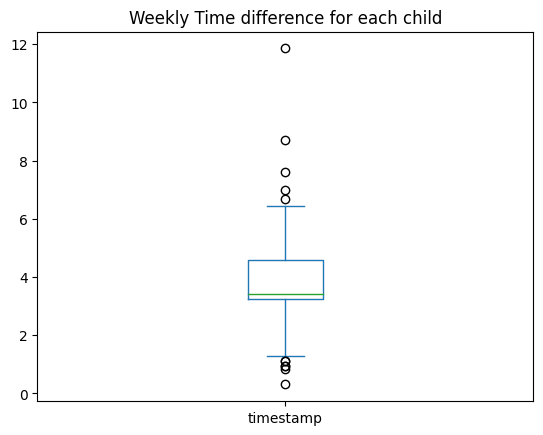

In [20]:
time_difference_per_child.to_pandas().plot(kind='box')
plt.title("Weekly Time difference for each child")
plt.show()

In [21]:

train_series['timestamp'] = pd.to_datetime(train_series['timestamp'].to_numpy())

train_series['date'] = train_series['timestamp'].dt.day

merged_data_sorted = train_series.sort_values(by='timestamp')

first_day_data_per_child = merged_data_sorted.groupby(['id_map', 'date']).first().reset_index()

first_day_data_per_child

,id_map,date,step,timestamp,anglez,enmo
0,0,1,299880,2018-09-01,-54.386200,0.0018
1,0,2,317160,2018-09-02,-32.767700,0.0340
2,0,3,334440,2018-09-03,-38.103699,0.0130
3,0,4,351720,2018-09-04,-58.597099,0.0236
4,0,5,369000,2018-09-05,-64.165298,0.0288
...,...,...,...,...,...,...
7074,276,27,384840,2017-08-27,43.403198,0.0000
7075,276,28,402120,2017-08-28,2.068500,0.0055
7076,276,29,419400,2017-08-29,47.675999,0.0000
7077,276,30,436680,2017-08-30,30.219700,0.0000


/opt/conda/lib/python3.10/site-packages/cudf/core/groupby/groupby.py:1217: RuntimeWarning: GroupBy.apply() performance scales poorly with number of groups. Got 538 groups. Some functions may perform better by passing engine='jit'
  warnings.warn(


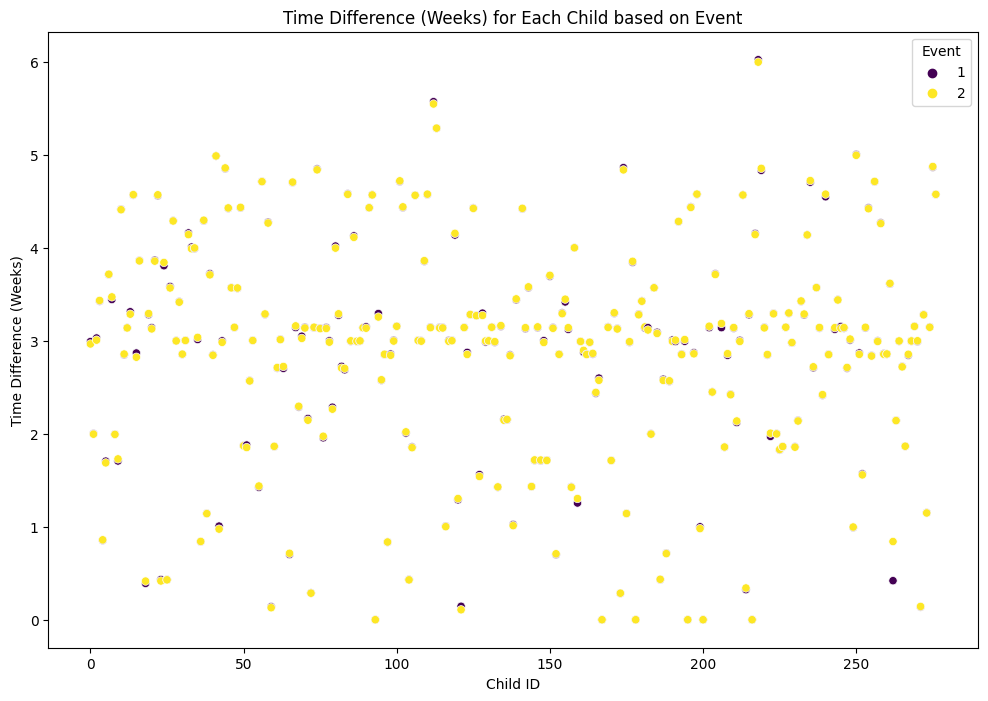

In [22]:
import seaborn as sns

train['timestamp'] = pd.to_datetime(train['timestamp'].to_pandas())

time_difference_per_child = train.groupby(['id_map', 'event'])['timestamp'].apply(lambda x: (x.max() - x.min()) / pd.Timedelta(weeks=1)).reset_index(name='time_difference_weeks')

plt.figure(figsize=(12, 8))
sns.scatterplot(x='id_map', y='time_difference_weeks', hue='event', data=time_difference_per_child.to_pandas(), palette='viridis')
plt.title('Time Difference (Weeks) for Each Child based on Event')
plt.xlabel('Child ID')
plt.ylabel('Time Difference (Weeks)')
plt.legend(title='Event', loc='upper right')
plt.show()


In [23]:


train_series['timestamp'] = pd.to_datetime(train_series['timestamp'].to_pandas())

time_difference_per_child = train_series.groupby('id_map')['timestamp'].apply(lambda x: (x.max() - x.min()) / pd.Timedelta(minutes=1)).reset_index(name='time_difference')

anglez_mean_per_child = train_series.groupby('id_map')['anglez'].mean().reset_index(name='anglez_mean')

enmo_mean_per_child = train_series.groupby('id_map')['enmo'].mean().reset_index(name='enmo_mean')

summary_per_child = pd.merge(time_difference_per_child.to_pandas(), anglez_mean_per_child.to_pandas(), on='id_map')
summary_per_child = pd.merge(summary_per_child, enmo_mean_per_child.to_pandas(), on='id_map')

plt.figure(figsize=(10, 6))
sns.scatterplot(x='time_difference', y='anglez_mean', data=summary_per_child, hue='id_map', palette='viridis', legend=False)
plt.title('Time Difference vs Anglez Mean for Each Child')
plt.xlabel('Time Difference (minutes)')
plt.ylabel('Anglez Mean')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='time_difference', y='enmo_mean', data=summary_per_child, hue='id_map', palette='viridis', legend=False)
plt.title('Time Difference vs Enmo Mean for Each Child')
plt.xlabel('Time Difference (minutes)')
plt.ylabel('Enmo Mean')
plt.show()


MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /opt/conda/include/rmm/mr/device/cuda_memory_resource.hpp

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train['timestamp'] = pd.to_datetime(train['timestamp'].to_pandas())

# Calculate the time difference for each child based on event
time_difference_per_child = train.groupby(['id_map', 'timestamp'])['event'].apply(lambda x: (x.max() - x.min()) / pd.Timedelta(minutes=1)).reset_index(name='time_difference')

# Create a scatter plot for time difference vs id_map, colored by event
plt.figure(figsize=(12, 8))
sns.scatterplot(x='id_map', y='time_difference', hue='event', data=time_difference_per_child.to_pandas(), palette='viridis')
plt.title('Time Difference for Each Child based on Event')
plt.xlabel('Child ID')
plt.ylabel('Time Difference (minutes)')
plt.legend(title='Event', loc='upper right')
plt.show()


/opt/conda/lib/python3.10/site-packages/cudf/core/groupby/groupby.py:1217: RuntimeWarning: GroupBy.apply() performance scales poorly with number of groups. Got 9584 groups. Some functions may perform better by passing engine='jit'
  warnings.warn(


TypeError: unsupported operand type(s) for /: 'numpy.uint8' and 'Timedelta'

In [25]:
train_series['timestamp'] = pd.to_datetime(train_series['timestamp'].to_pandas())
child_177_data = train_series[train_series['id_map'] == 127]
child_177_data = child_177_data.sort_values(by='timestamp')
time_diff_minutes = child_177_data['timestamp'].diff().mean().total_seconds()
print(f"The average time difference between consecutive steps for id_map 127 is approximately: {time_diff_minutes:.2f} seconds")

The average time difference between consecutive steps for id_map 127 is approximately: 5.00 seconds


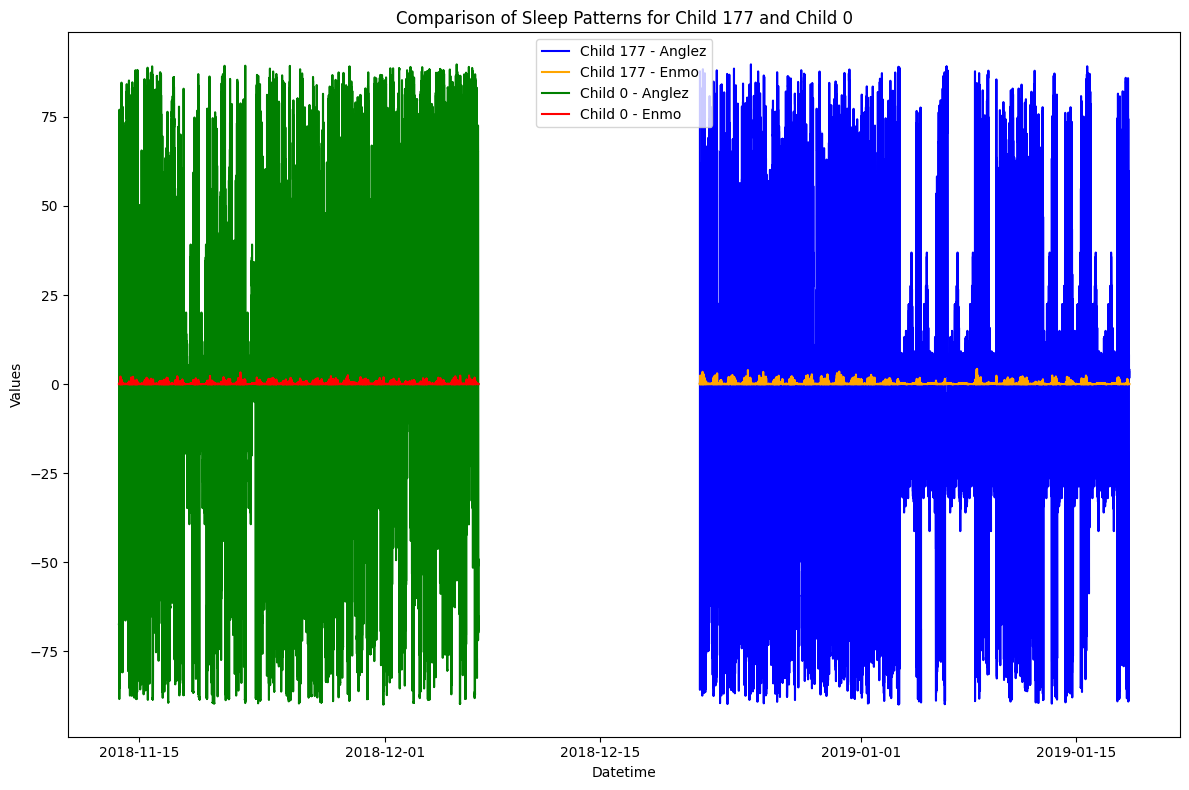

In [26]:
child_177_data = train_series[train_series['id_map'] == 177].to_pandas()
child_0_data = train_series[train_series['id_map'] == 12].to_pandas()
plt.figure(figsize=(12, 8))
sns.lineplot(data=child_177_data, x='timestamp', y='anglez', label='Child 177 - Anglez', color='blue')
sns.lineplot(data=child_177_data, x='timestamp', y='enmo', label='Child 177 - Enmo', color='orange')
sns.lineplot(data=child_0_data, x='timestamp', y='anglez', label='Child 0 - Anglez', color='green')
sns.lineplot(data=child_0_data, x='timestamp', y='enmo', label='Child 0 - Enmo', color='red')

plt.title('Comparison of Sleep Patterns for Child 177 and Child 0')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# filtered_data = train[train['event'].to_pandas().isin([1, 2])]
# selected_data = filtered_data.groupby(['id_map', 'event']).head(30)
# plt.figure(figsize=(12, 8))
# sns.scatterplot(data=selected_data.to_pandas(), x='timestamp', y='anglez', hue='id_map', style='event', s=100, palette='viridis')
# plt.title('Anglez for First 30 Observations for Each Child with Event')
# plt.xlabel('Timestamp')
# plt.ylabel('Anglez')
# plt.legend(title='Child ID', bbox_to_anchor=(1, 1), loc='upper left')

# plt.figure(figsize=(12, 8))
# sns.scatterplot(data=selected_data.to_pandas(), x='timestamp', y='enmo', hue='id_map', style='event', s=100, palette='viridis')
# plt.title('Enmo for First 30 Observations for Each Child with Event')
# plt.xlabel('Timestamp')
# plt.ylabel('Enmo')
# plt.legend(title='Child ID', bbox_to_anchor=(1, 1), loc='upper left')

# plt.show()


### Selecting child with the highest number of steps for univariate analysis 

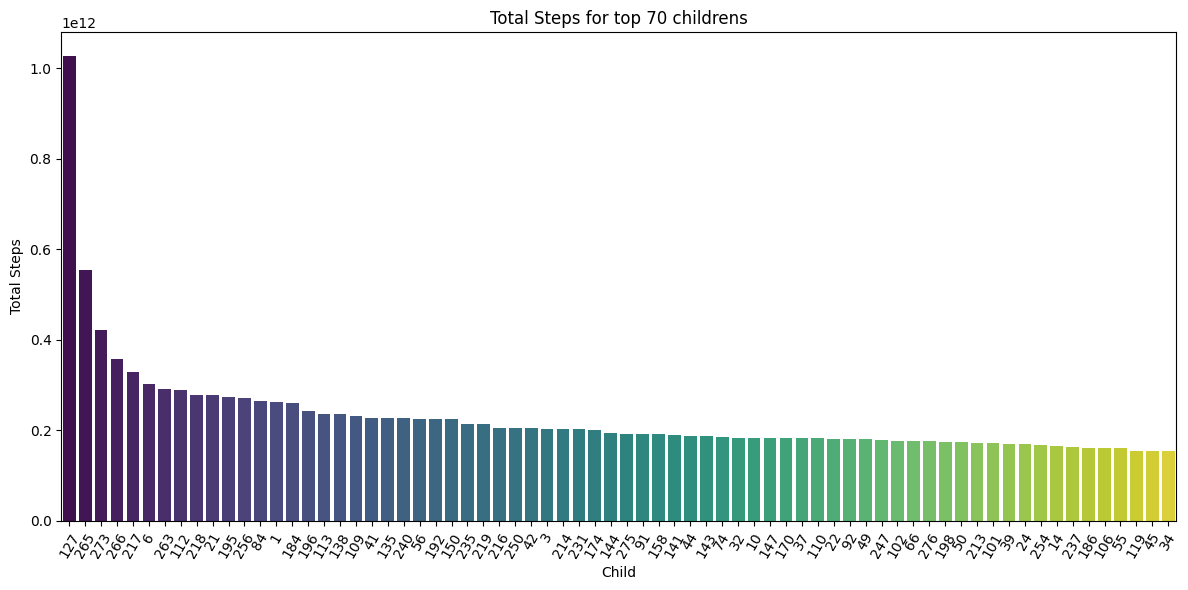

Child ID with the highest number of steps: 127


In [27]:
total_steps_per_child = train_series.groupby('id_map').agg({'step': 'sum'}).reset_index()

total_steps_per_child = total_steps_per_child.sort_values(by='step', ascending=False)

top_70 = total_steps_per_child.head(70)

child_ids = top_70['id_map']
total_steps = top_70['step']

colors = sns.color_palette("viridis", n_colors=len(top_70))

plt.figure(figsize=(12, 6))
sns.barplot(x=child_ids.to_numpy(), y=total_steps.to_numpy(), palette=colors, order=top_70.sort_values('step', ascending=False)['id_map'].to_numpy())
plt.xlabel('Child')
plt.ylabel('Total Steps')
plt.title('Total Steps for top 70 childrens')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

max_steps_child = top_70.iloc[0]  # Access the first row (highest steps)
print("Child ID with the highest number of steps:", max_steps_child['id_map'])


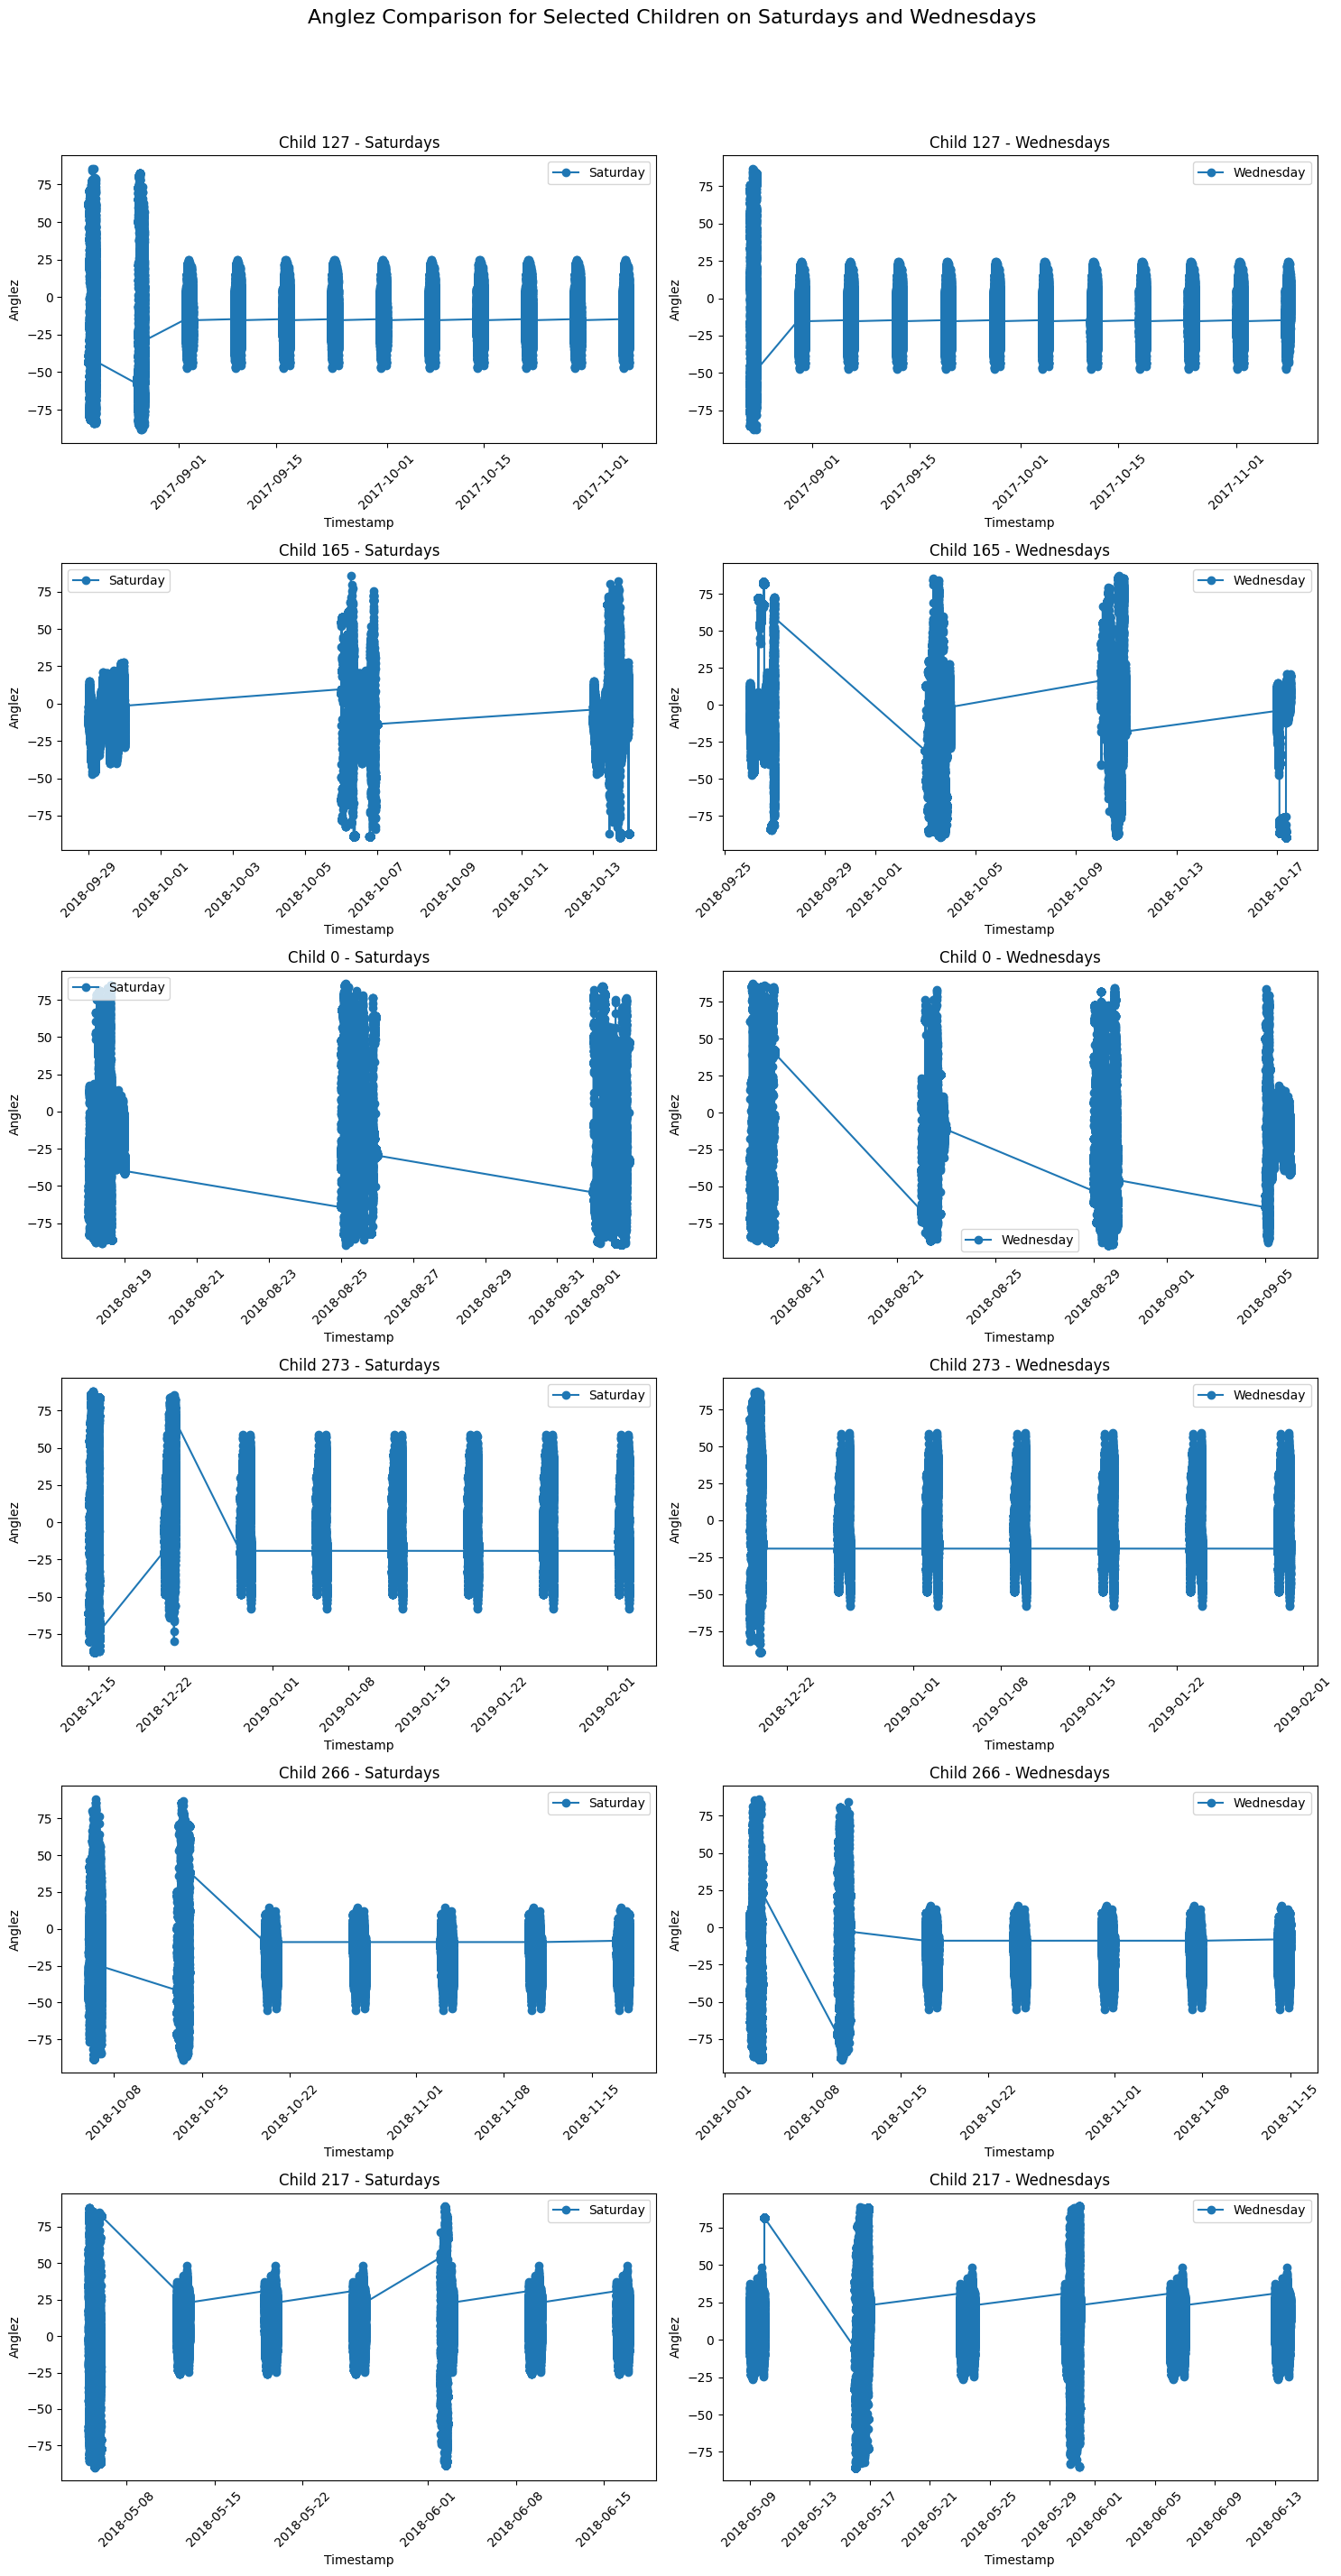

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

day_name_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

selected_childs = [127, 165, 0, 273, 266, 217]

selected_data = train_series[train_series['id_map'].isin(selected_childs)]

selected_data['timestamp'] = pd.to_datetime(selected_data['timestamp'].to_numpy())

selected_data['day_name'] = selected_data['timestamp'].dt.dayofweek.map(day_name_mapping)

fig, axes = plt.subplots(nrows=len(selected_childs), ncols=2, figsize=(15, 5 * len(selected_childs)))
fig.suptitle('Anglez Comparison for Selected Children on Saturdays and Wednesdays', fontsize=16)

for i, child_id in enumerate(selected_childs):
    child_data_sat = selected_data[(selected_data['id_map'] == child_id) & (selected_data['day_name'] == 'Saturday')]
    child_data_wed = selected_data[(selected_data['id_map'] == child_id) & (selected_data['day_name'] == 'Wednesday')]
    
    # Plot for Saturdays
    axes[i, 0].plot(child_data_sat['timestamp'], child_data_sat['anglez'], label='Saturday', marker='o')
    axes[i, 0].set_title(f'Child {child_id} - Saturdays')
    axes[i, 0].set_xlabel('Timestamp')
    axes[i, 0].set_ylabel('Anglez')
    axes[i, 0].legend()
    axes[i, 0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability
    
    # Plot for Wednesdays
    axes[i, 1].plot(child_data_wed['timestamp'], child_data_wed['anglez'], label='Wednesday', marker='o')
    axes[i, 1].set_title(f'Child {child_id} - Wednesdays')
    axes[i, 1].set_xlabel('Timestamp')
    axes[i, 1].set_ylabel('Anglez')
    axes[i, 1].legend()
    axes[i, 1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("Comparison_with_dates.png")
plt.show()


Mean: 0.04131506958020833 and Std of Series Enmo: 0.1018289300940901


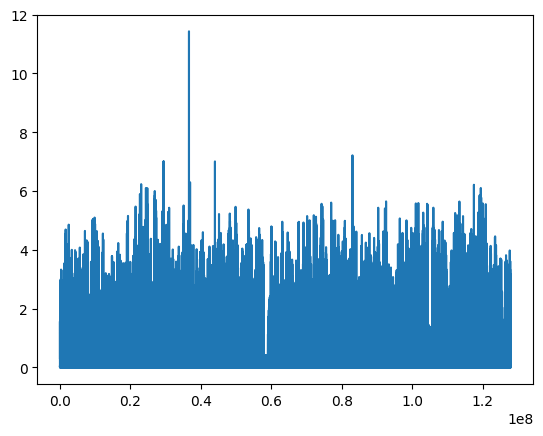

In [29]:
mean_enmo = train_series['enmo'].mean()
std_enmo = train_series['enmo'].std()

plt.plot(train_series['enmo'])
print(f"Mean: {mean_enmo} and Std of Series Enmo: {std_enmo}")

# Data Analysis for single child

In [30]:
child_df = train_series[train_series['id_map'] == max_steps_child[0]]
# child_df = train_series[train_series['id_map'] == 34]

child_df['timestamp'] = cudf.to_datetime(child_df['timestamp'], unit='s')

print(child_df.shape)
print(child_df.head())

(1433880, 6)
          step           timestamp     anglez    enmo  id_map  date
57604860     0 2017-08-17 16:45:00  -0.709000  0.0521     127    17
57604861     1 2017-08-17 16:45:05  26.159300  0.0415     127    17
57604862     2 2017-08-17 16:45:10 -19.055300  0.0312     127    17
57604863     3 2017-08-17 16:45:15 -56.735001  0.0486     127    17
57604864     4 2017-08-17 16:45:20 -59.033001  0.0350     127    17


In [31]:
len(child_df), len(train_series[train_series['id_map'] == max_steps_child[0]])

(1433880, 1433880)

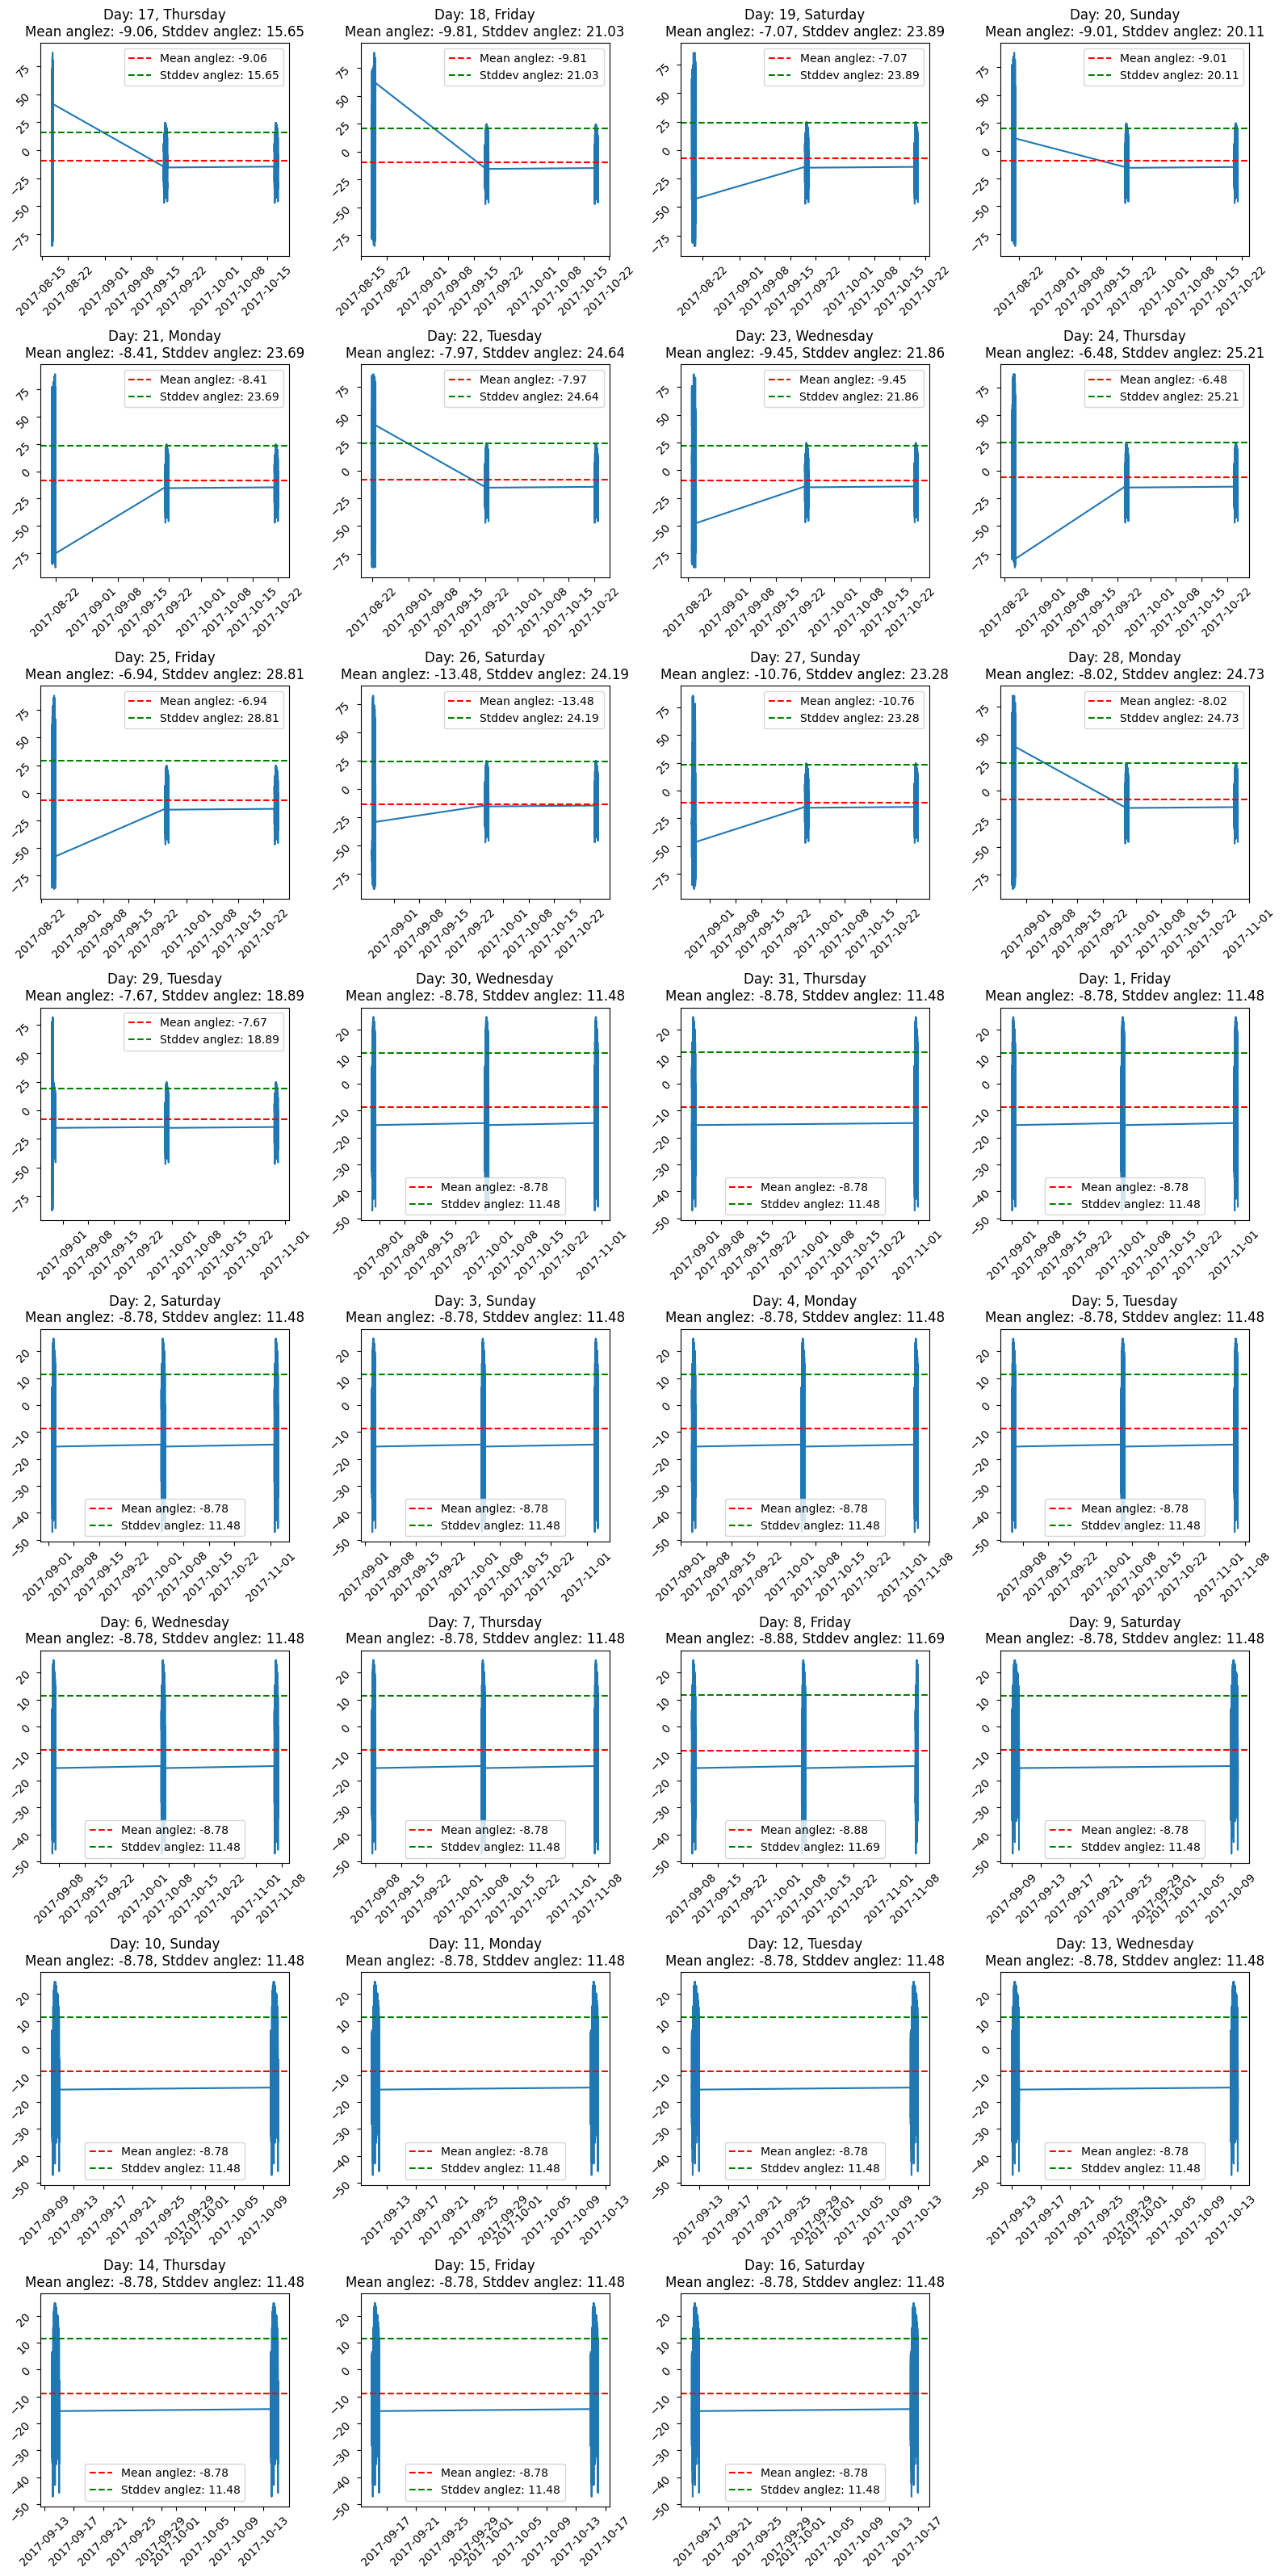

In [32]:
child_df['timestamp'] = cudf.to_datetime(child_df['timestamp'], unit='s')
days = child_df['timestamp'].dt.day.unique().to_pandas()
num_rows = len(days) // 4 + (len(days) % 4 > 0)
num_cols = min(len(days), 4)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 4 * num_rows))
axes = axes.flatten()

for idx, day in enumerate(days):
    day_data = child_df[child_df['timestamp'].dt.day == day]
    
    axes[idx].plot(day_data['timestamp'].to_pandas(), day_data['anglez'].to_pandas())
    axes[idx].tick_params(labelrotation=45)
    
    day_of_week = day_data['timestamp'].dt.strftime('%A').iloc[0]
    
    mean_anglez = day_data['anglez'].mean()
    std_anglez = day_data['anglez'].std()
    
    title = f"Day: {day}, {day_of_week}\nMean anglez: {mean_anglez:.2f}, Stddev anglez: {std_anglez:.2f}"
    axes[idx].set_title(title)
    
    axes[idx].axhline(y=mean_anglez, color='red', linestyle='--', label=f'Mean anglez: {mean_anglez:.2f}')
    axes[idx].axhline(y=std_anglez, color='green', linestyle='--', label=f'Stddev anglez: {std_anglez:.2f}')
    
    axes[idx].legend()

for i in range(len(days), num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

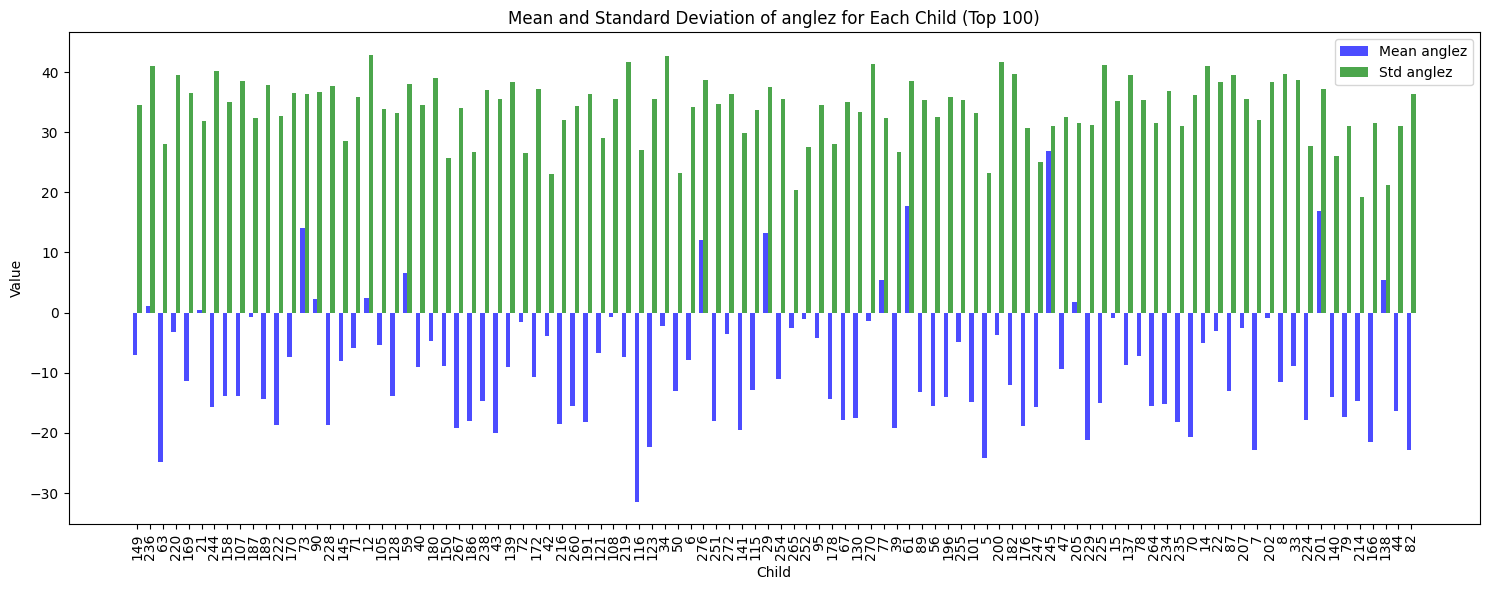

In [33]:
mean_std_df = train_series.groupby('id_map').agg({'anglez': ['mean', 'std']}).reset_index()
child_ids = mean_std_df['id_map']
mean_values = mean_std_df['anglez', 'mean']
std_values = mean_std_df['anglez', 'std']
top_n = 100
index = cp.asnumpy(cp.arange(len(child_ids.to_numpy())))[:top_n]
mean_values_np = cp.asnumpy(mean_values)[:top_n]
std_values_np = cp.asnumpy(std_values)[:top_n]
fig, ax = plt.subplots(figsize=(15, 6))
bar_width = 0.35

bar1 = ax.bar(index, mean_values_np, bar_width, label='Mean anglez', alpha=0.7, color='b')
bar2 = ax.bar(index + bar_width, std_values_np, bar_width, label='Std anglez', alpha=0.7, color='g')

ax.set_xlabel('Child')
ax.set_ylabel('Value')
ax.set_title('Mean and Standard Deviation of anglez for Each Child (Top 100)')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([str(label[0]) for label in cp.asnumpy(child_ids.to_numpy()[:top_n])])

ax.legend()

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


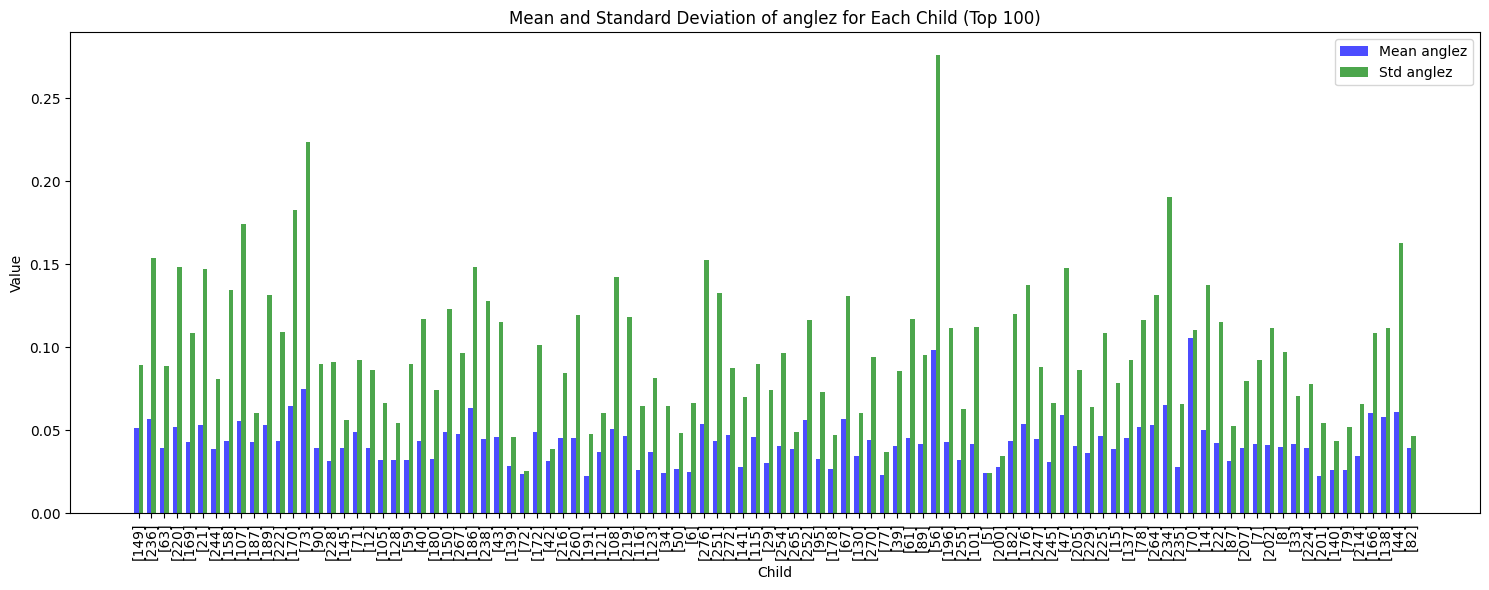

In [34]:
mean_std_df = train_series.groupby('id_map').agg({'enmo': ['mean', 'std']}).reset_index()

child_ids = mean_std_df['id_map']
mean_values = mean_std_df['enmo', 'mean']
std_values = mean_std_df['enmo', 'std']

top_n = 100
index = cp.asnumpy(cp.arange(len(child_ids.to_numpy())))[:top_n]
mean_values_np = cp.asnumpy(mean_values)[:top_n]
std_values_np = cp.asnumpy(std_values)[:top_n]

fig, ax = plt.subplots(figsize=(15, 6))
bar_width = 0.35

bar1 = ax.bar(index, mean_values_np, bar_width, label='Mean anglez', alpha=0.7, color='b')
bar2 = ax.bar(index + bar_width, std_values_np, bar_width, label='Std anglez', alpha=0.7, color='g')

ax.set_xlabel('Child')
ax.set_ylabel('Value')
ax.set_title('Mean and Standard Deviation of anglez for Each Child (Top 100)')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(cp.asnumpy(child_ids.to_numpy()[:top_n]))
ax.legend()

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Sleep durations for each child

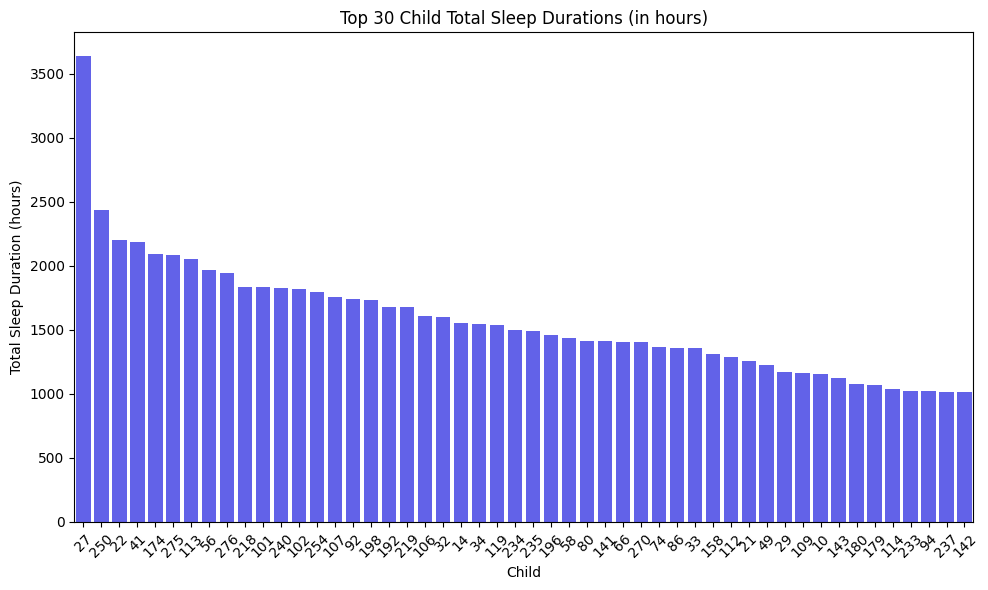

In [35]:
train['step'] = train['step'].astype('float32')
onset_data = train[train['event'] == 1].loc[:, ['id_map', 'step']]
wakeup_data = train[train['event'] == 2].loc[:, ['id_map', 'step']]

sleep_data = onset_data.merge(wakeup_data, on='id_map', how='inner')

sleep_data['sleep_duration'] = (sleep_data['step_y'] - sleep_data['step_x']) / 3600
total_sleep_durations = sleep_data.groupby('id_map').agg({'sleep_duration': 'sum'}).reset_index()
sorted_sleep_durations = total_sleep_durations.sort_values('sleep_duration', ascending=False)
top_30_sleep_durations = sorted_sleep_durations.head(50)
child_ids = top_30_sleep_durations['id_map']
sleep_durations = top_30_sleep_durations['sleep_duration']

plt.figure(figsize=(10, 6))
sns.barplot(x=child_ids.to_pandas(), y=sleep_durations.to_pandas(), color='b', alpha=0.7, order=child_ids.to_pandas())
plt.xlabel('Child')
plt.ylabel('Total Sleep Duration (hours)')
plt.title('Top 30 Child Total Sleep Durations (in hours)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_47/2390661892.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(onset_stats['hour'].to_numpy(), hist=False,
/tmp/ipykernel_47/2390661892.py:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(wakeup_stats['hour'].to_numpy(), hist=False,


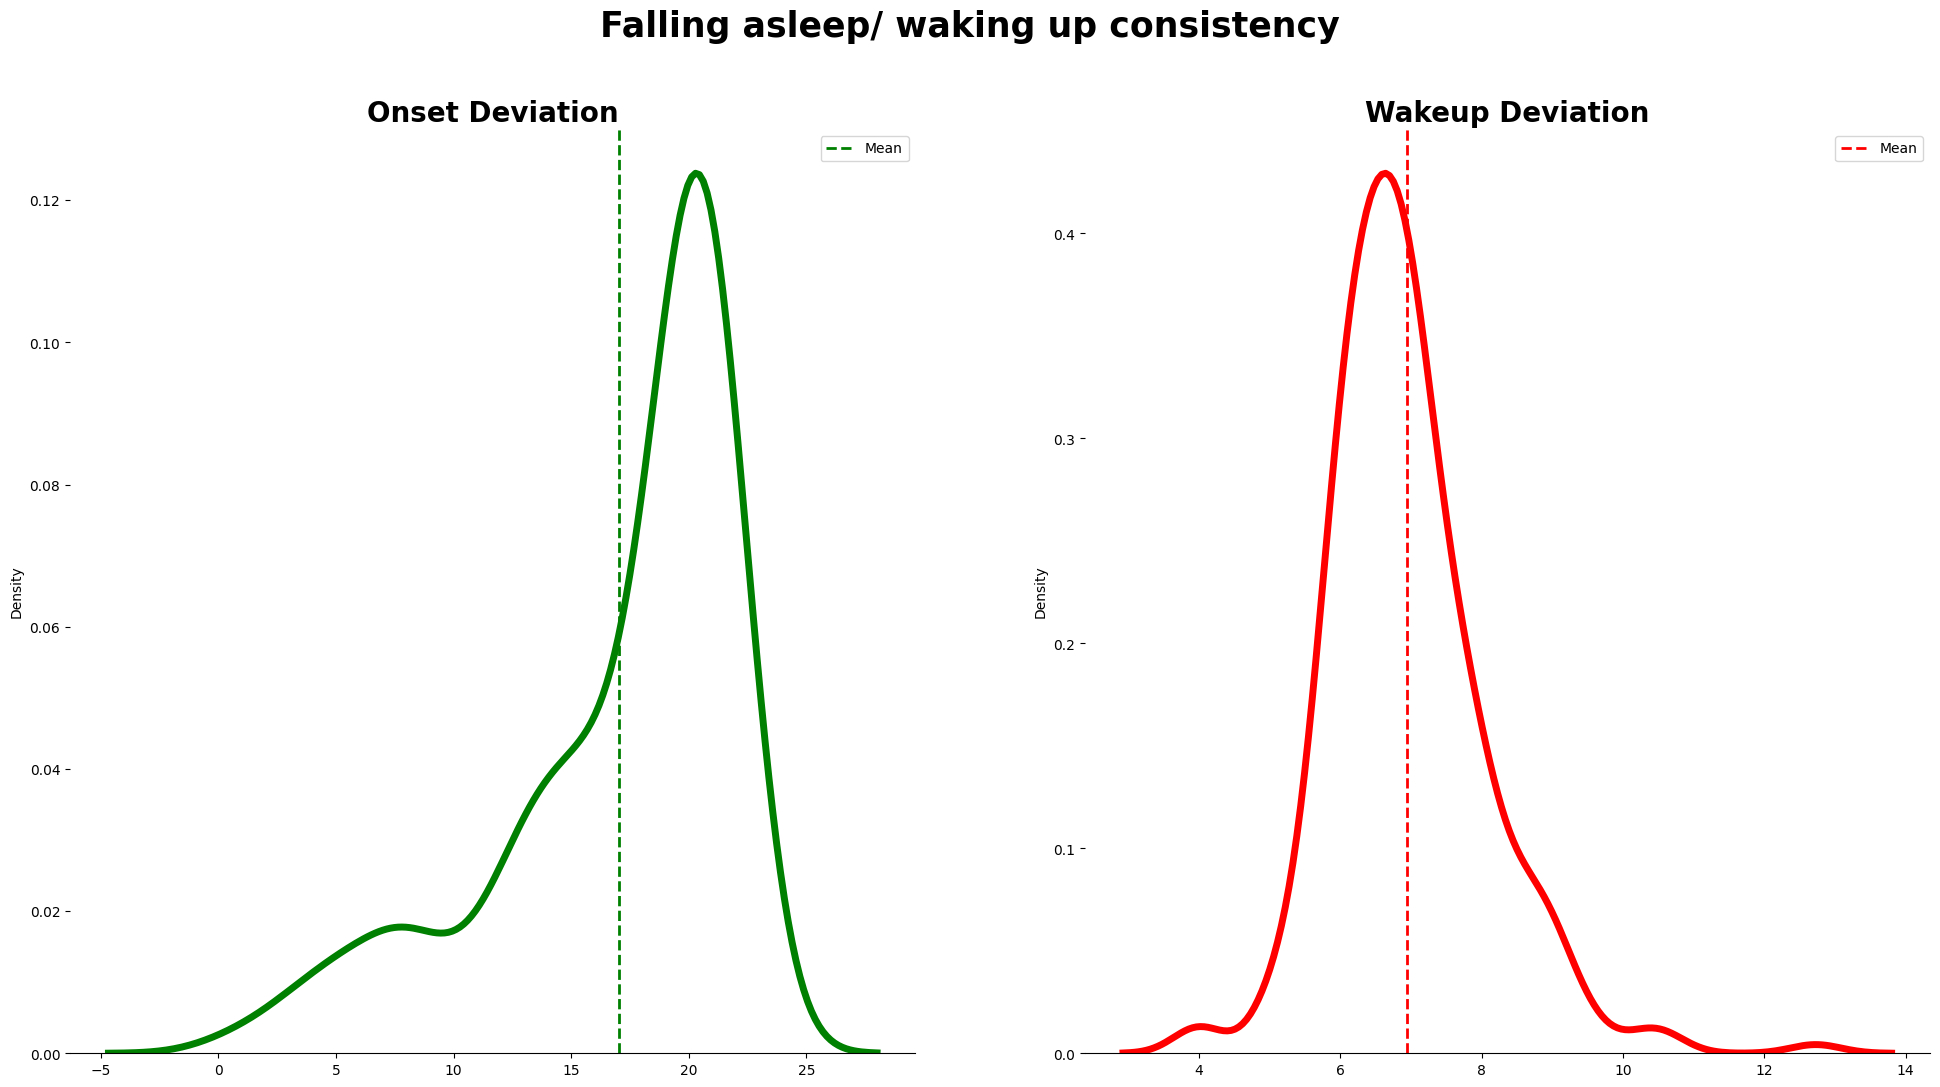

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

train.dropna(inplace=True)
train["hour"] = train.timestamp.dt.hour
onset_stats = train[train.event == 1].groupby(by=["id_map"])['hour'].mean().reset_index()
onset_stats['std'] = train[train.event == 1].groupby(by=["id_map"])['hour'].std().reset_index()['hour']

wakeup_stats = train[train.event == 2].groupby(by=["id_map"])['hour'].mean().reset_index()
wakeup_stats['std'] = train[train.event == 2].groupby(by=["id_map"])['hour'].std().reset_index()['hour']
onset_stats.dropna(inplace=True)
wakeup_stats.dropna(inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))
fig.suptitle('Falling asleep/ waking up consistency', weight="bold", size=25)

sns.distplot(onset_stats['hour'].to_numpy(), hist=False,
             rug_kws={"color": "black"},
             kde_kws={"color": "green", "lw": 5, "alpha": 1},
             ax=ax1)
ax1.axvline(onset_stats['hour'].mean(), color='green', linestyle='dashed', linewidth=2, label='Mean')
ax1.set_title('Onset Deviation', weight="bold", size=20)
ax1.legend()

sns.distplot(wakeup_stats['hour'].to_numpy(), hist=False,
             rug_kws={"color": "blue"},
             kde_kws={"color": "red", "lw": 5, "alpha": 1},
             ax=ax2)
ax2.axvline(wakeup_stats['hour'].mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
ax2.set_title('Wakeup Deviation', weight="bold", size=20)
ax2.legend()

sns.despine(right=True, top=True, left=True)

plt.savefig("Sleep_pattern_with_means.png")
plt.show()


#### Sleep pattern for each child

In [37]:
from tqdm import tqdm
unique_id_maps = train_series['id_map'].to_pandas().unique()

num_rows = (len(unique_id_maps) + 2) // 3
num_cols = min(len(unique_id_maps), 3)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for idx, id_map in tqdm(enumerate(unique_id_maps), total=len(unique_id_maps)):
    child_data = train_series[train_series['id_map'] == id_map]
    child_data_pd = cudf.DataFrame(child_data)
    axes[idx].plot(child_data_pd['timestamp'], child_data_pd['anglez'], label='anglez')
    axes[idx].plot(child_data_pd['timestamp'], child_data_pd['enmo'], label='enmo')
    axes[idx].set_title(f'Daily Sleep Patterns for Child {id_map}')
    axes[idx].set_xlabel('Timestamp')
    axes[idx].set_ylabel('Values')
    axes[idx].legend()

plt.tight_layout()
plt.show()

100%|██████████| 277/277 [00:34<00:00,  8.00it/s]


KeyboardInterrupt: 

#### Good sleep considering 8 hours

In [38]:
train['step'] = train['step'].astype('int32')
onset_events = train[train['event'] == 1].groupby('id_map')['step'].min()
wakeup_events = train[train['event'] == 2].groupby('id_map')['step'].max()

sleep_durations = wakeup_events - onset_events
good_sleep_duration = 8 * 60

good_sleep_quality = sleep_durations >= good_sleep_duration
poor_sleep_quality = sleep_durations < good_sleep_duration
print("Good Sleep Quality:")
print(cp.asnumpy(sleep_durations[good_sleep_quality]))
print("\nPoor Sleep Quality:")
print(cp.asnumpy(sleep_durations[poor_sleep_quality]))
print("\nGood Sleep Quality (Pandas):")
print(sleep_durations[good_sleep_quality].to_pandas())
print("\nPoor Sleep Quality (Pandas):")
print(sleep_durations[poor_sleep_quality].to_pandas())

Good Sleep Quality:
[364920 249132 368556 422916 110832 212376 456372 423336 248004 213288
 539232 352560 386184 404028 559296 347940 473856  55608 403356 385044
 473544 559788  57708 472752  58296 436248 526608 368592 420252 351192
 370680 508440 490776 490788 371748 106104 525984 144696 457740 351852
 611172 125004 369108 595512 539976 437340 386892 437544 539508 229392
 231576 317124 369684 180540 576648 404544 522636  20880 231396 334548
 370836 334296  92076 574440 389496 284604 374040 386412 266172  40044
 386400 591924 387324 244956 387720 367296 279768 491712 404220 336468
 332640 560148 369360 505332 367680 370092 386784 387852 543060 560664
   6156 402516 319032 351816 108132 350760 370032 387348 579828 544428
 249120  57708 231348 558216 370416 370344 473712 559704 388308 678336
 646956 387084 387540 129588 369504 370440 508164 164796  19008 387360
 351804 401796 540804 402396 194052 402120 368100 368448 387396 367200
 179100 386832 267096 267696 351852 130320 421116 540756 

In [ ]:
# X_rem = train['anglez'].mean()
# Y_rem = train['enmo'].mean()
# X_non_rem = train['anglez'].mean()
# Y_non_rem = train['enmo'].mean()

# # Identify REM and non-REM segments
# rem_criteria = (train['anglez'] > X_rem) & (train['enmo'] < Y_rem)
# rem_data = train[rem_criteria]

# non_rem_criteria =  (train['anglez'] > X_rem) & (train['enmo'] < Y_rem)
# non_rem_data = train[non_rem_criteria]

# plt.figure(figsize=(12, 6))

# # Plot REM sleep in blue
# plt.scatter(rem_data['timestamp'].to_numpy(), rem_data['anglez'].to_numpy(), c='b', label='REM')

# # Plot non-REM sleep in red
# plt.scatter(non_rem_data['timestamp'].to_numpy(), non_rem_data['anglez'].to_numpy(), c='r', label='NREM')

# plt.xlabel('Timestamp')
# plt.ylabel('anglez')
# plt.title('REM and NREM Sleep Segments')
# plt.legend()
# plt.show()

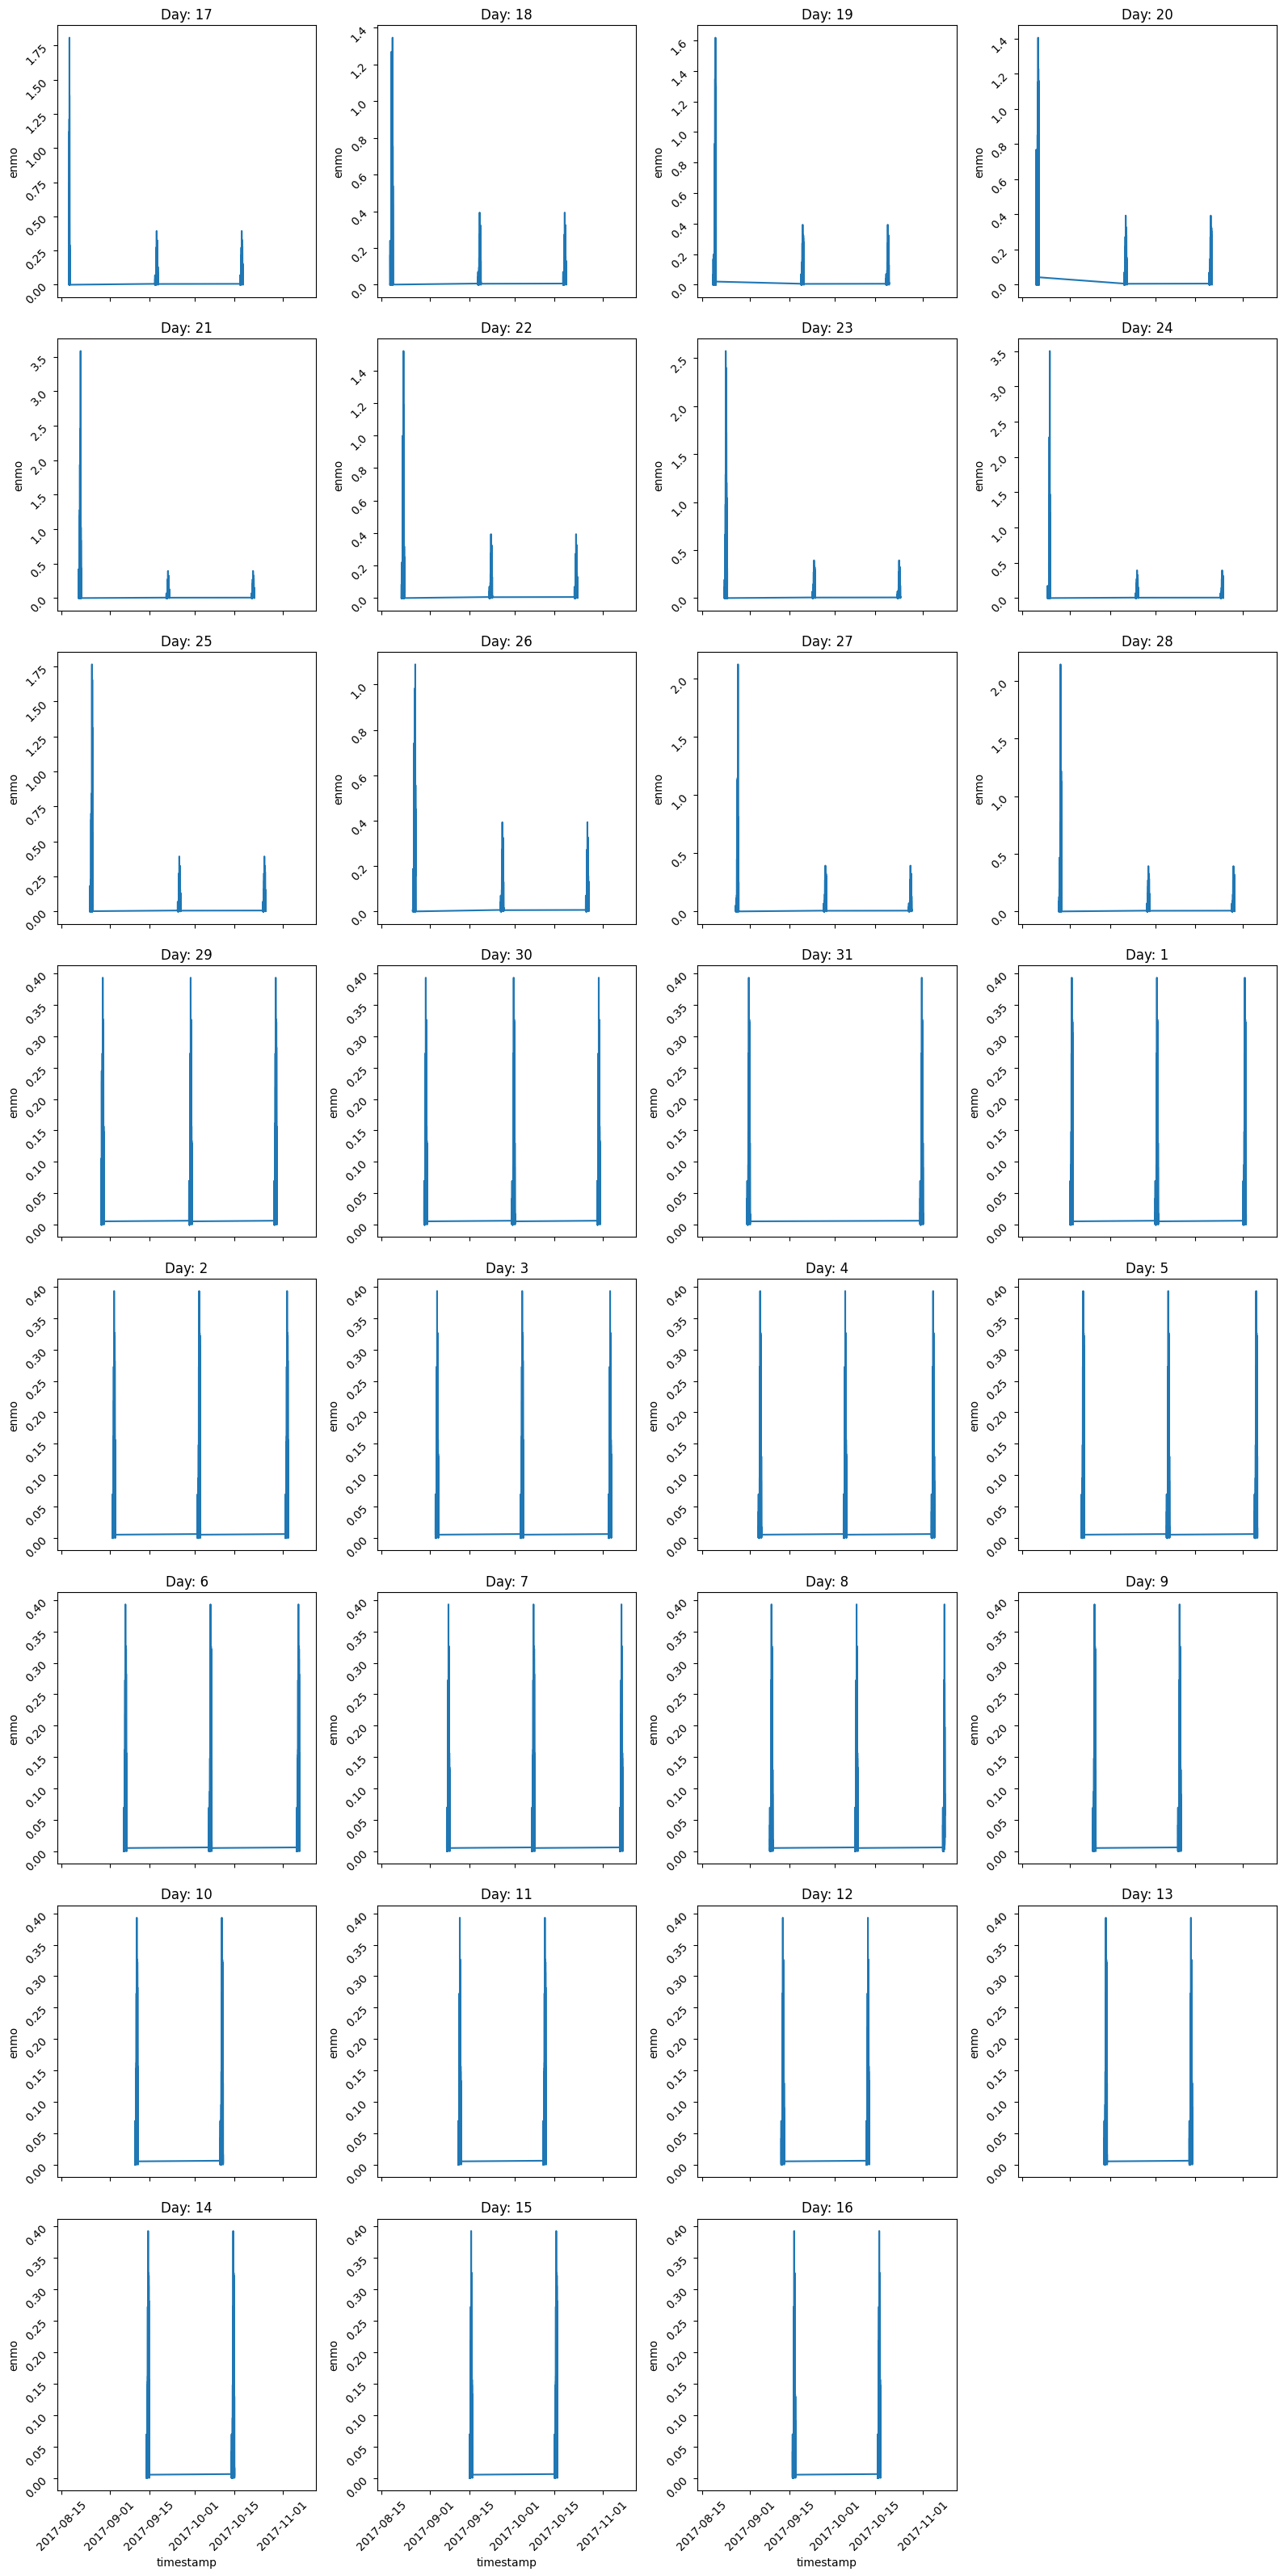

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

child_df['timestamp'] = child_df['timestamp'].astype('datetime64[ms]')

days = child_df['timestamp'].dt.day.unique().to_numpy()

num_rows = len(days) // 4 + (len(days) % 4 > 0)
num_cols = min(len(days), 4)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 4 * num_rows), sharex=True)

axes = axes.flatten()

for idx, day in enumerate(days):
    day_data = child_df[child_df['timestamp'].dt.day == day]
    sns.lineplot(x='timestamp', y='enmo', data=day_data.to_pandas(), ax=axes[idx])
    axes[idx].tick_params(labelrotation=45)
    axes[idx].set_title("Day: " + str(day))

for i in range(len(days), num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [40]:
anglez_means = []
anglez_stds = []

missing_days = [i for i in range(0, days.max()) if i not in days]
print("Missing days:", missing_days)

anglez_mean = child_df['anglez'].mean()
anglez_std = child_df['anglez'].std()

Missing days: [0]


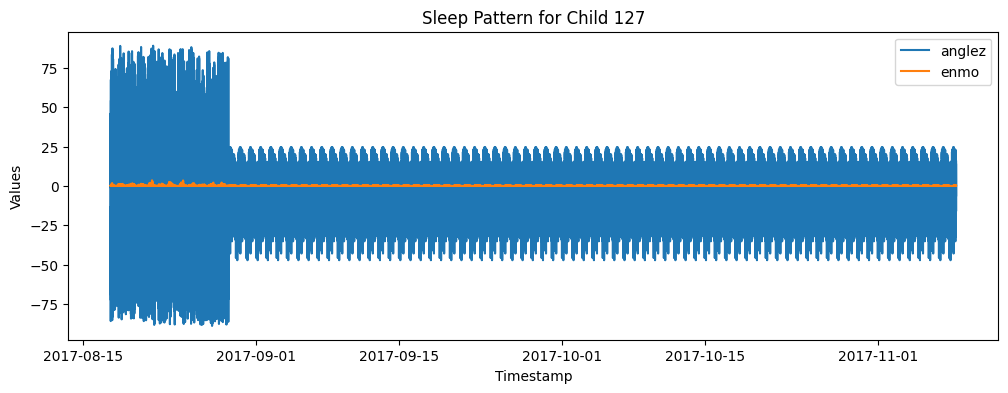

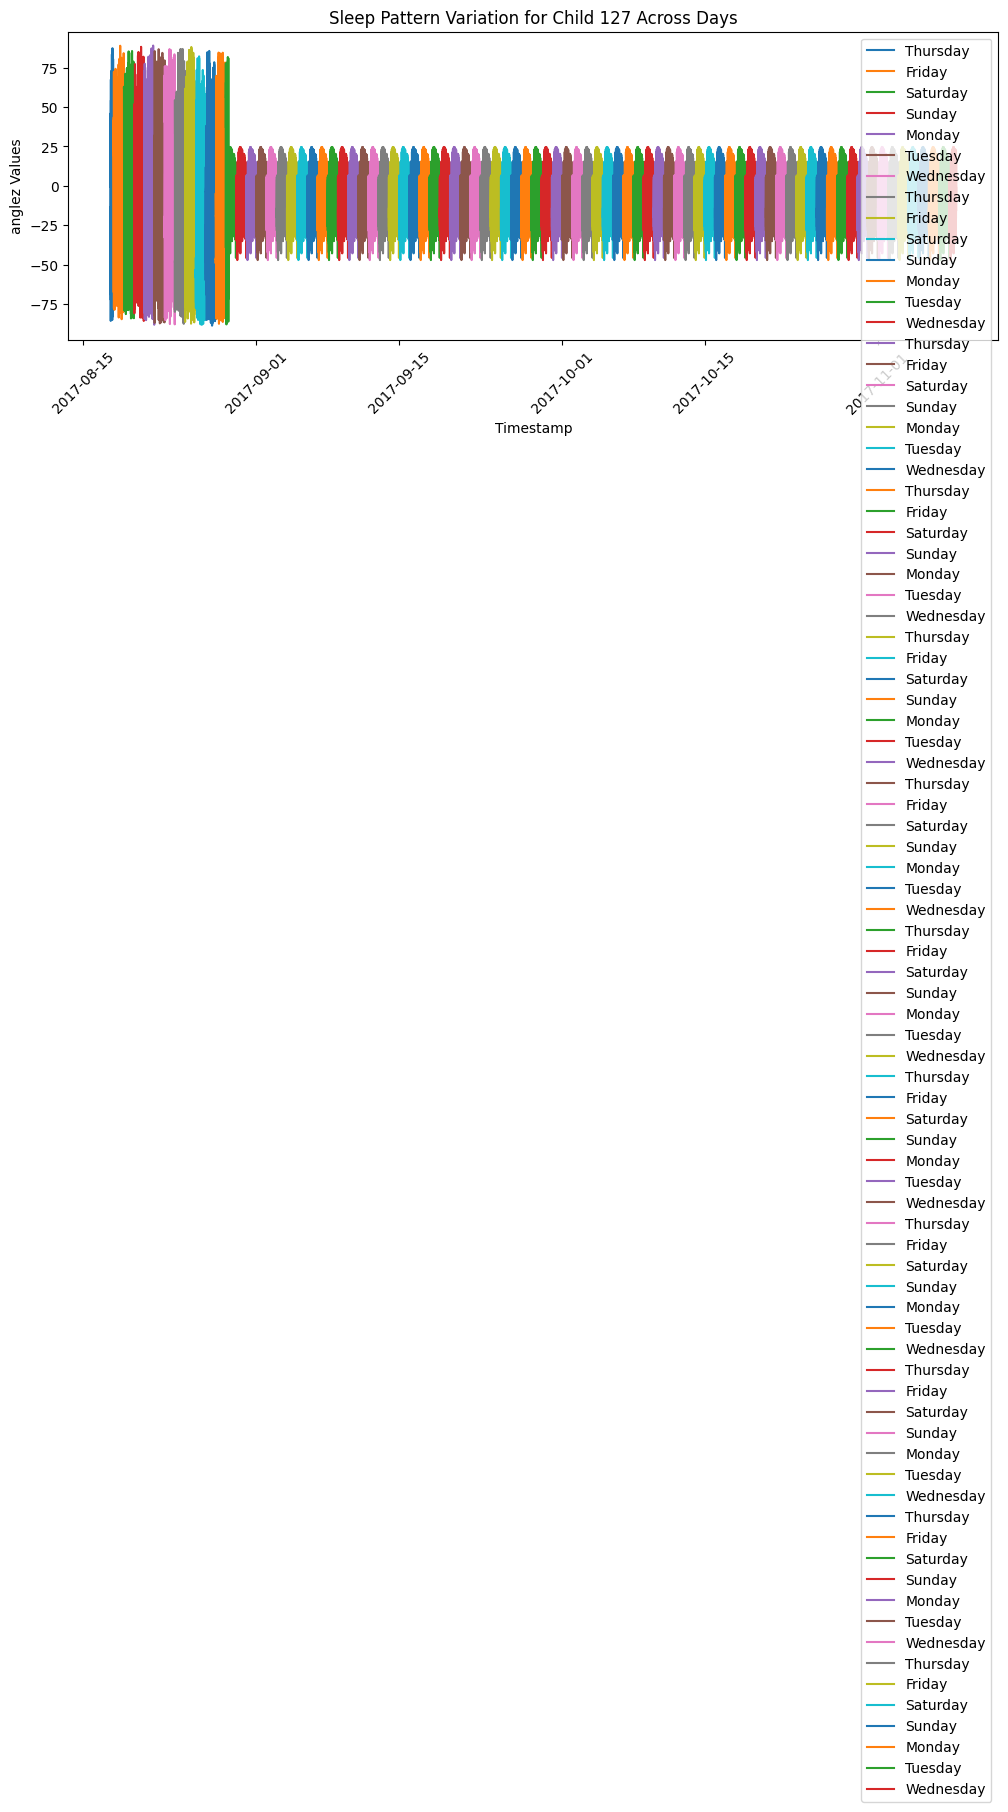

In [41]:
child_id = max_steps_child[0]

# 1. What is the sleep pattern for a specific child over time?
child_data = train_series[train_series['id_map'] == child_id].to_pandas()
plt.figure(figsize=(12, 4))
plt.plot(child_data['timestamp'], child_data['anglez'], label='anglez')
plt.plot(child_data['timestamp'], child_data['enmo'], label='enmo')
plt.title(f'Sleep Pattern for Child {child_id}')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.legend()
plt.show()

# 2. How does the sleep pattern change during different days for a child?
plt.figure(figsize=(12, 4))
for day, day_data in child_data.groupby(child_data['timestamp'].dt.date):
    plt.plot(day_data['timestamp'], day_data['anglez'], label=f'{day.strftime("%A")}')
    
plt.title(f'Sleep Pattern Variation for Child {child_id} Across Days')
plt.xlabel('Timestamp')
plt.ylabel('anglez Values')

plt.xticks(rotation=45)
plt.legend()
plt.show()

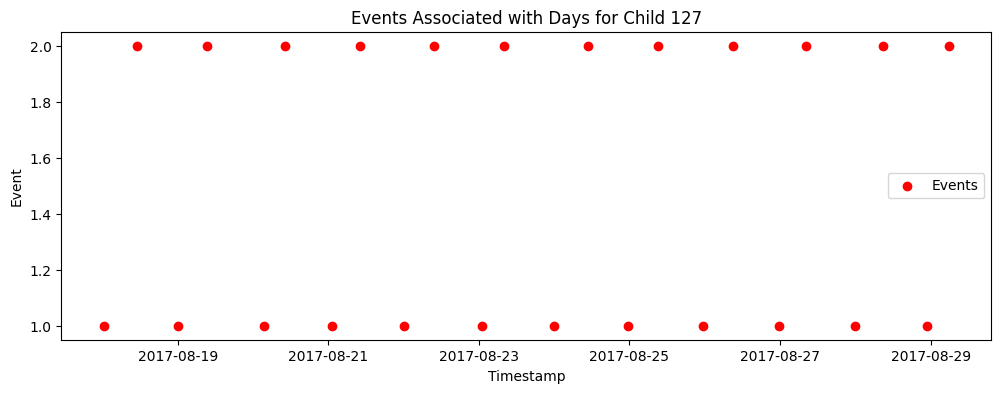

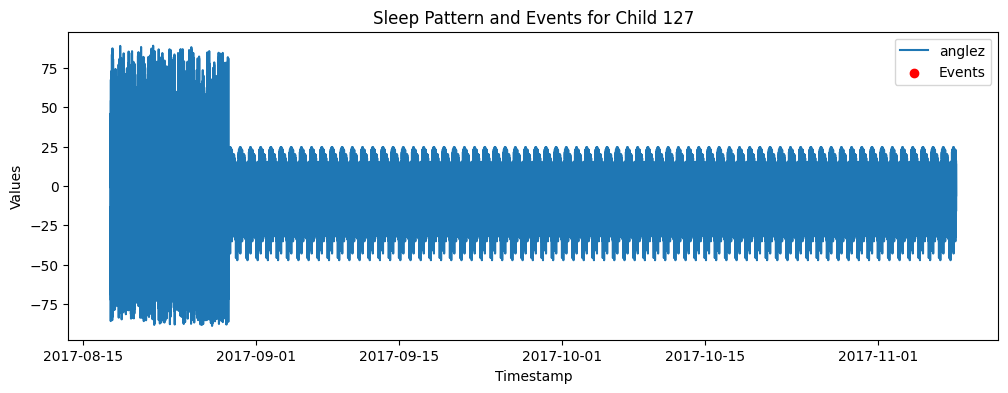

In [42]:
# 4. What events are associated with each day for a specific child?
child_events = train[train['id_map'] == child_id].to_pandas()
plt.figure(figsize=(12, 4))
plt.scatter(child_events['timestamp'], child_events['event'], label='Events', color='red')
plt.title(f'Events Associated with Days for Child {child_id}')
plt.xlabel('Timestamp')
plt.ylabel('Event')
plt.legend()
plt.show()

# 5. Is there a correlation between specific events and changes in sleep patterns?
plt.figure(figsize=(12, 4))
plt.plot(child_data['timestamp'], child_data['anglez'], label='anglez')
plt.scatter(child_events['timestamp'], child_events['event'], label='Events', color='red')
plt.title(f'Sleep Pattern and Events for Child {child_id}')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.legend()
plt.show()

### Comparing sleep pattern for 2 child

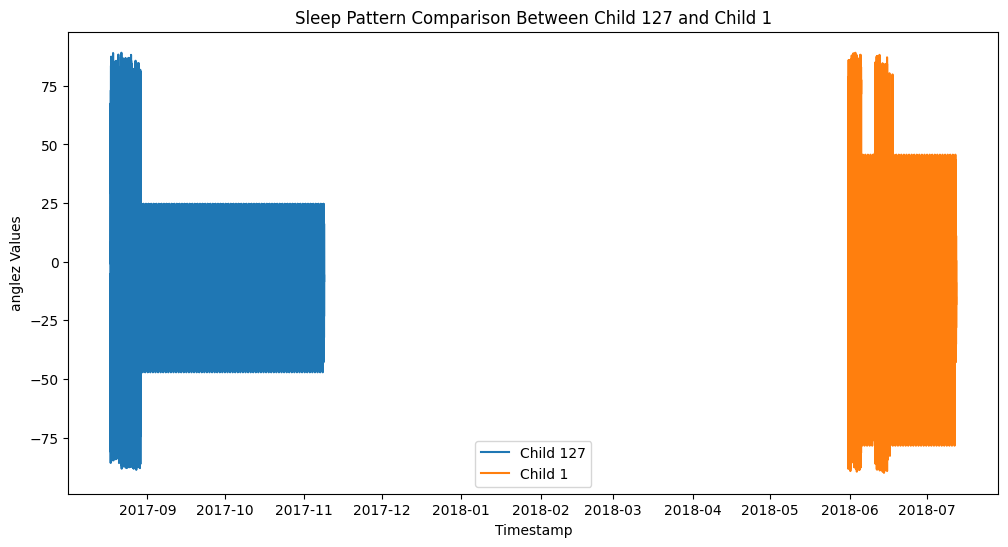

In [43]:
# Select two child ids for comparison
child_id1 = 127
child_id2 = 1

# Extract data for the selected children
child_data1 = train_series[train_series['id_map'] == child_id1].to_pandas()
child_data2 = train_series[train_series['id_map'] == child_id2].to_pandas()

# Compare sleep patterns
plt.figure(figsize=(12, 6))
plt.plot(child_data1['timestamp'], child_data1['anglez'], label=f'Child {child_id1}')
plt.plot(child_data2['timestamp'], child_data2['anglez'], label=f'Child {child_id2}')
plt.title(f'Sleep Pattern Comparison Between Child {child_id1} and Child {child_id2}')
plt.xlabel('Timestamp')
plt.ylabel('anglez Values')
plt.legend()
plt.show()

In [44]:
import scipy.stats as stats

# Question 1: Average sleep duration for each child
avg_sleep_duration_child1 = train_series[train_series['id_map'] == child_id1]['anglez'].mean()
avg_sleep_duration_child2 = train_series[train_series['id_map'] == child_id2]['anglez'].mean()

# Perform t-test
t_stat, p_value = stats.ttest_ind(train_series[train_series['id_map'] == child_id1]['anglez'].to_pandas(),
                                  train_series[train_series['id_map'] == child_id2]['anglez'].to_pandas())

print(f"Average Sleep Duration for Child {child_id1}: {avg_sleep_duration_child1:.2f} hours")
print(f"Average Sleep Duration for Child {child_id2}: {avg_sleep_duration_child2:.2f} hours")
print(f"T-Statistic: {t_stat:.4f}, P-Value: {p_value:.4f}")

# Question 2: Correlation between events and changes in sleep patterns
correlation_coefficient, p_value_corr = stats.pearsonr(child_data['step'], child_data['anglez'])

print(f"Correlation Coefficient: {correlation_coefficient:.4f}, P-Value: {p_value_corr:.4f}")

Average Sleep Duration for Child 127: -8.78 hours
Average Sleep Duration for Child 1: -3.32 hours
T-Statistic: -174.3026, P-Value: 0.0000
Correlation Coefficient: 0.0003, P-Value: 0.7365


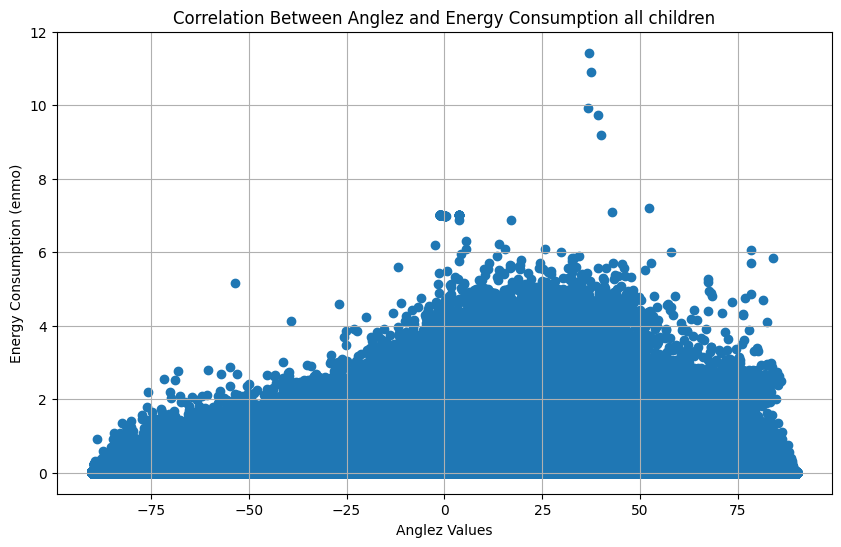

In [45]:
plt.figure(figsize=(10, 6))
plt.scatter(train_series['anglez'].to_pandas(), train_series['enmo'].to_pandas())
plt.title('Correlation Between Anglez and Energy Consumption all children')
plt.xlabel('Anglez Values')
plt.ylabel('Energy Consumption (enmo)')
plt.grid(True)
plt.show()

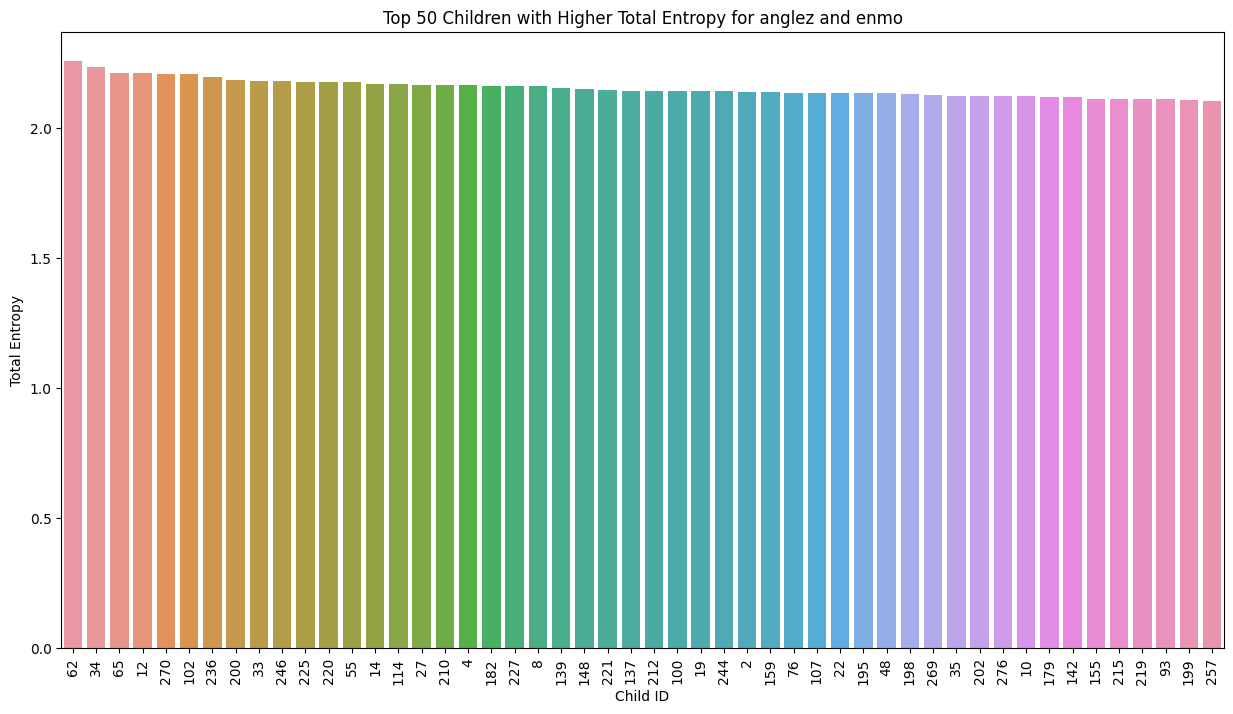

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

num_bins = 5
series['anglez_bin'] = pd.cut(series['anglez'], bins=num_bins, labels=False)
series['enmo_bin'] = pd.cut(series['enmo'], bins=num_bins, labels=False)

def calculate_entropy(column):
    prob_distribution = column.value_counts(normalize=True)
    information_content = -np.log2(prob_distribution)
    entropy = (prob_distribution * information_content).sum()
    return entropy

series['anglez_entropy'] = series.groupby('id_map')['anglez_bin'].transform(calculate_entropy)
series['enmo_entropy'] = series.groupby('id_map')['enmo_bin'].transform(calculate_entropy)

series['total_entropy'] = series['anglez_entropy'] + series['enmo_entropy']

top_50_children = series.groupby('id_map')['total_entropy'].max().nlargest(50).reset_index()
top_50 = series[series.id_map.isin(top_50_children.id_map.to_list())]

plt.figure(figsize=(15, 8))
sns.barplot(x='id_map', y='total_entropy', data=top_50_children, order=top_50_children['id_map'])
plt.title('Top 50 Children with Higher Total Entropy for anglez and enmo')
plt.xlabel('Child ID')
plt.ylabel('Total Entropy')
plt.xticks(rotation=90)
plt.show()


# Further steps:
- Comparitive analysis
- Techniques to reduce number of rows to faster train models.

# Machine Learning

In [2]:
%%time 

from IPython.display import display_html, clear_output, Markdown;
from gc import collect;
from copy import deepcopy;
import pandas as pd
from typing import Dict, List, Tuple;
import numpy as np;
from datetime import datetime;
import numpy as np;
# import cudf
from pprint import pprint;
import os;
from functools import partial;
from collections import Counter;
from itertools import product;
from colorama import Fore, Style, init;
from warnings import filterwarnings;
filterwarnings('ignore');

from tqdm.notebook import tqdm;
import seaborn as sns;

import matplotlib.pyplot as plt;
%matplotlib inline

clear_output();
print();


CPU times: user 1.26 s, sys: 338 ms, total: 1.6 s
Wall time: 1.3 s


In [3]:
%%time 

# Data engineering and pipeline development:-
from sklearn.model_selection import (RepeatedStratifiedKFold as RSKF, 
                                     StratifiedKFold as SKF,
                                     KFold, 
                                     RepeatedKFold as RKF, 
                                     cross_val_score,
                                     train_test_split
                                    );

from sklearn.pipeline import Pipeline, make_pipeline;
from sklearn.base import BaseEstimator, TransformerMixin;
from sklearn.compose import ColumnTransformer;
from sklearn.metrics import average_precision_score as aps, accuracy_score, classification_report, mean_squared_error

# Model development:-
from xgboost import XGBClassifier;
from lightgbm import LGBMClassifier, log_evaluation, early_stopping;
from catboost import CatBoostClassifier;
from sklearn.ensemble import (RandomForestClassifier as RFC,
                              ExtraTreesClassifier as ETC,
                              GradientBoostingClassifier as GBC,
                              HistGradientBoostingClassifier as HGBC,
                             );

CPU times: user 1.31 s, sys: 192 ms, total: 1.5 s
Wall time: 2.3 s


In [4]:
%%time
series = pd.read_parquet("/kaggle/input/detect-sleep-states-memory-decrease/train_series.parquet")
events = pd.read_parquet(r"/kaggle/input/detect-sleep-states-memory-decrease/train_events.parquet")
childsr = series[series['id_map'] == 127]
childev = events[events['id_map'] == 127]    


series.drop(['timestamp'], axis=1, inplace=True)
series.dropna(inplace=True)
series.reset_index(inplace=True, drop=True)
events.drop(['timestamp'], axis=1, inplace=True)
events.dropna(inplace=True)
events.reset_index(inplace=True, drop=True)

holdout_frac = 0.2  # 20% of data as holdout set
series_train, series_holdout = train_test_split(series, test_size=holdout_frac, random_state=42)
events_train, events_holdout = train_test_split(events, test_size=holdout_frac, random_state=42)

CPU times: user 32.5 s, sys: 15.9 s, total: 48.4 s
Wall time: 1min


In [51]:
print("Series columns:", series.columns)
print("Events columns:", events.columns)

Series columns: Index(['step', 'anglez', 'enmo', 'id_map'], dtype='object')
Events columns: Index(['night', 'event', 'step', 'id_map'], dtype='object')


In [ ]:
childsr = series[series['id_map'] == 127]
childev = events[events['id_map'] == 127]    

# joined_frame = pd.merge(childsr, childev, how='left', on='id_map')
joined_frame = pd.merge(events, series)
print(joined_frame.shape)
joined_frame.head()

In [ ]:
# child_ids = series.id_map.unique()
# for sample_percent in range(10, 100, 10):
#     sample_data = pd.DataFrame(columns = ['step_x', 'anglez', 'enmo', 'id_map', 'night', 'event', 'step_y'])
#     for child_id in tqdm(child_ids):
#         child_series = series_train[series.id_map == child_id].sample(frac=0.05)
#         child_events = events_train[events.id_map == child_id].sample(frac = 0.05)
        
#         joined_frame = pd.merge(childsr, childev, how='left', on='id_map')
    
#         sample_data = pd.concat([sample_data, joined_frame])
#     break

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# joined_frame = pd.merge(childsr, childev, how='left', on='id_map')
joined_frame.dropna(inplace=True)
joined_frame.reset_index(inplace=True, drop=True)

joined_frame_df = joined_frame
float16_columns = ['step', 'anglez', 'enmo', 'id_map', 'night', 'event']
joined_frame_df[float16_columns] = joined_frame_df[float16_columns].astype('float32')
print(joined_frame_df.shape)
joined_frame_df.head()


In [ ]:
X = joined_frame_df.drop("event", axis=1).to_numpy()
y = joined_frame_df.event.to_numpy()
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2,random_state=42)

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_val = imputer.fit_transform(X_val)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [ ]:
# Check data balancing
# df = pd.DataFrame(list(y_train.items()), columns=['ID', 'Value'])

# plt.figure(figsize=(10, 6))
# sns.countplot(x='Value', data=df, palette='viridis')
# plt.title('Value Counts')
# plt.xlabel('Value')
# plt.ylabel('Count')
# plt.show()

### Base model (Gradient Boosting Classifier)

In [ ]:
n_splits = 30
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

gbc = GBC(n_estimators=500)
# gbc.fit(X_train, y_train)

# train_preds = gbc.predict(X_train)
# test_preds = gbc.predict(X_val)
# print("Train Classification report: ")
# print(classification_report(y_train, train_preds))
# print("Test Classification report: ")
# print(classification_report(y_val, test_preds))
mse_scores = []
acc_scores = []
for fold_num, (train_index, test_index) in tqdm(enumerate(kf.split(X), 1), total=n_splits):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    gbc.fit(X_train, y_train)
    y_pred = gbc.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    mse_scores.append(mse)
    acc_scores.append(acc)
#     plt.figure(figsize=(10, 6))
#     plt.scatter(y_test, y_pred)
#     plt.title(f'Fold {fold_num} - True vs Predicted Values')
#     plt.xlabel('True Values')
#     plt.ylabel('Predicted Values')
#     plt.show()


n_splits = len(mse_scores)

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(range(1, n_splits + 1), mse_scores, marker='o', linestyle='-', color='b', label='MSE')
ax1.set_xlabel('Fold Number')
ax1.set_ylabel('Mean Squared Error', color='b')
ax1.tick_params('y', colors='b')
ax1.set_title('Mean Squared Error and Accuracy for Each Fold')

ax2 = ax1.twinx()
ax2.plot(range(1, n_splits + 1), acc_scores, marker='o', linestyle='-', color='r', label='Accuracy')
ax2.set_ylabel('Accuracy', color='r')
ax2.tick_params('y', colors='r')

# Displaying the legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()


In [ ]:
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define base classifiers
base_classifiers = [
    ('xgb', XGBClassifier()),
    ('lgbm', LGBMClassifier()),
    ('catboost', CatBoostClassifier(verbose=False)),
    ('rfc', RFC()),
    ('etc', ETC()),
    ('gbc', GBC()),
    ('hgbc', HGBC())
]

# Create a stacking classifier with a logistic regression meta-classifier
stacking_classifier = StackingClassifier(estimators=base_classifiers,
                                         final_estimator=LogisticRegression(),
                                         cv=KFold(n_splits=25, shuffle=True, random_state=42))

# Perform KFold cross-validation
kf = KFold(n_splits=25, shuffle=True, random_state=42)

accuracies = []
errors = []
for train_index, test_index in tqdm(kf.split(X), total=kf.get_n_splits(), desc='KFold Progress'):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the stacking classifier on the training set
    stacking_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = stacking_classifier.predict(X_test)

    # Evaluate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    error = mean_squared_error(y_test, y_pred)
    
    accuracies.append(accuracy)
    errors.append(error)
    print(f'Accuracy: {accuracy}')


In [ ]:

rf_model = RandomForestClassifier(n_estimators=10, max_depth=10)
knn_model = KNeighborsClassifier(n_neighbors=5)
lr_model = LogisticRegression()
mnb = MultinomialNB()


start = time()
rf_model.fit(X_train, y_train)
print("Elapsed training time (Random Forest):", time()-start)

start = time()
lr.fit(X_train, y_train)
print("Elapsed training time (Logistic Regression):", time()-start)

start = time()
knn_model.fit(X_train, y_train)
print("Elapsed training time (Logistic Regression):", time()-start)

y_pred_rf = rf_model.predict(X_val)
y_pred_knn = knn_model.predict(X_val)

X_stack = np.column_stack((y_pred_rf, y_pred_knn))

final_model = RandomForestClassifier(n_estimators=10, max_depth=10)
final_model.fit(X_stack, y_val)

y_pred_stacked = final_model.predict(X_stack)

accuracy = accuracy_score(y_val, y_pred_stacked)
print(f'Stacked Model Accuracy: {accuracy:.4f}')

In [ ]:
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt

y_prob = ensemble_model.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

threshold = 0.5
y_pred_binary = (y_prob > threshold).astype(int)

class_report = classification_report(y_val, y_pred_binary)
print(f'Classification Report:\n{class_report}')
